* 2019/08/24 - map leptonJet energy in $\eta-\phi$ plane to check if HEM affects.
* 2019/08/26 - adding plots for just counts
* 2019/08/29 - check for leading-only/electron-type-only

In [4]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import awkward
from FireHydrant.Tools.metfilter import MetFilters

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
datasets = json.load(open('../Samples/control_data2018.json'))

In [15]:
class leptonJetEnergyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        eta_axis = hist.Bin('eta', '$\eta$', 100, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 100, -np.pi, np.pi)
        
        self._accumulator = processor.dict_accumulator({
            'energy': hist.Hist('Energy', dataset_axis, eta_axis, phi_axis),
            'multiplicity': hist.Hist('Multiplicity', dataset_axis, eta_axis, phi_axis),
            'leading': hist.Hist('Leading leptonJet', dataset_axis, eta_axis, phi_axis),
            'electrontype': hist.Hist('Multiplicity', dataset_axis, eta_axis, phi_axis),
            'mutype': hist.Hist('Multiplicity', dataset_axis, eta_axis, phi_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset=df['dataset']
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        ljnmus = ((ljdautype==3)|(ljdautype==8)).astype(int).sum()
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        ljnmus = ljnmus[metfiltermask]
        
        output['energy'].fill(dataset=dataset, eta=leptonjets.eta.flatten(),
                             phi=leptonjets.phi.flatten(),
                             weight=leptonjets.p4.energy.flatten())
        output['multiplicity'].fill(dataset=dataset, eta=leptonjets.eta.flatten(),
                                   phi=leptonjets.phi.flatten())
        
        leadidx = leptonjets.pt.argmax()
        output['leading'].fill(dataset=dataset, eta=leptonjets[leadidx].eta.flatten(),
                              phi=leptonjets[leadidx].phi.flatten())
        
        electrontypemask = ljnmus<2
        output['electrontype'].fill(dataset=dataset, eta=leptonjets[electrontypemask].eta.flatten(),
                                    phi=leptonjets[electrontypemask].phi.flatten())
        output['mutype'].fill(dataset=dataset, eta=leptonjets[~electrontypemask].eta.flatten(),
                             phi=leptonjets[~electrontypemask].phi.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [16]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=leptonJetEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 3017/3017 [02:08<00:00, 23.40items/s]


#### counts

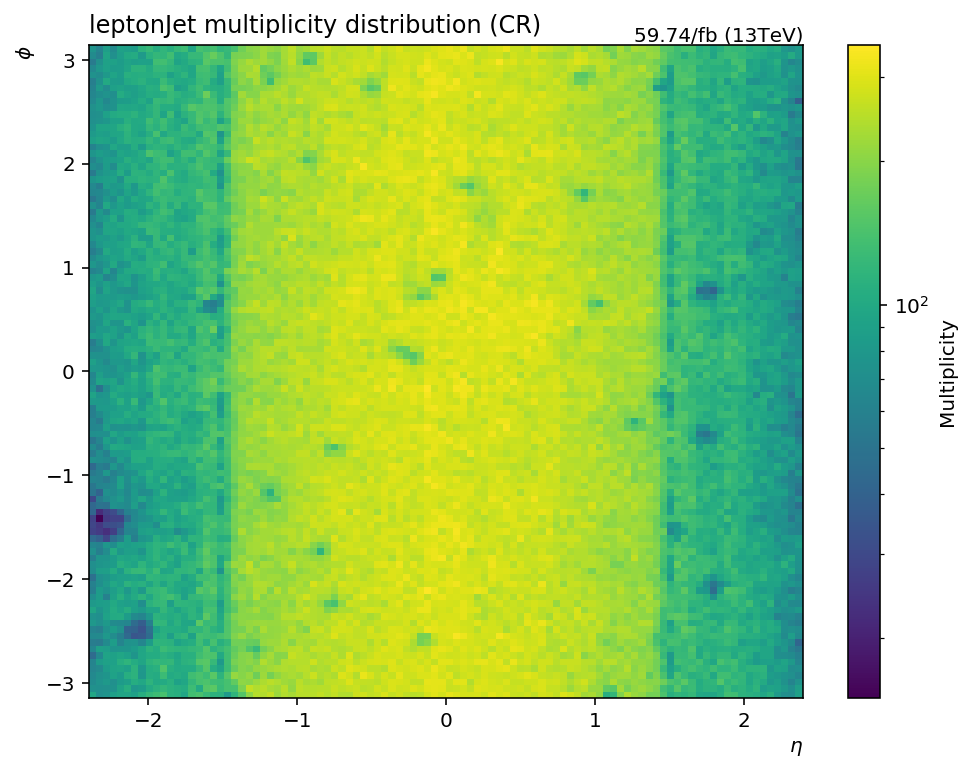

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['multiplicity'].project('dataset'), xaxis='eta', ax=ax, patch_opts=dict(norm=LogNorm()))

ax.set_title('leptonJet multiplicity distribution (CR)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

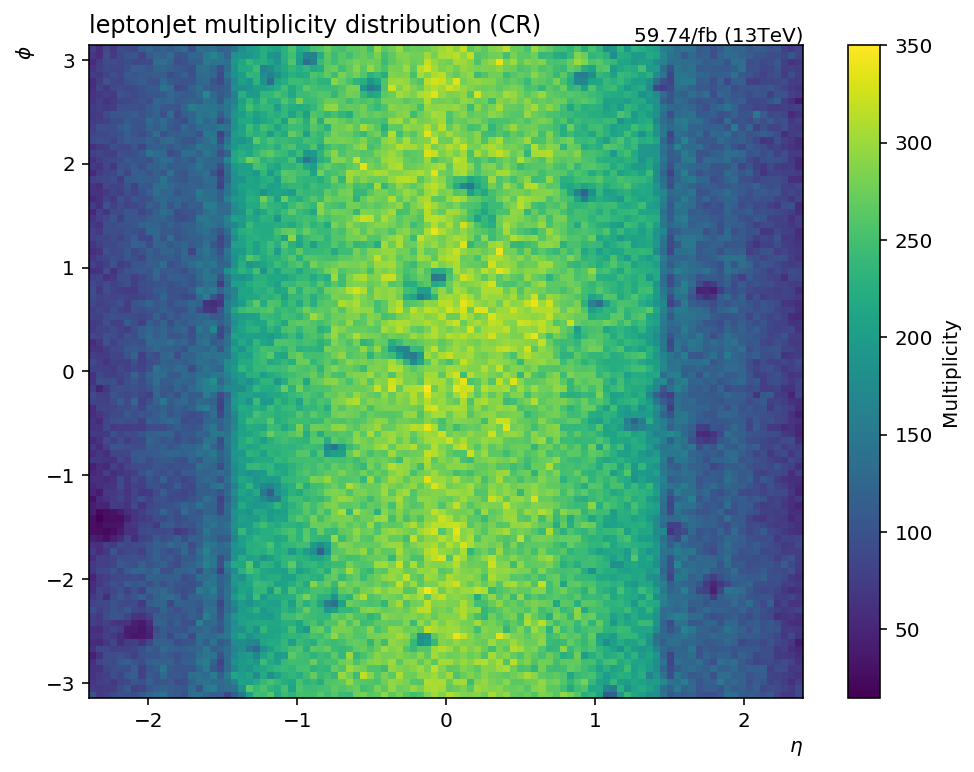

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['multiplicity'].project('dataset'), xaxis='eta', ax=ax,)

ax.set_title('leptonJet multiplicity distribution (CR)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

split by era

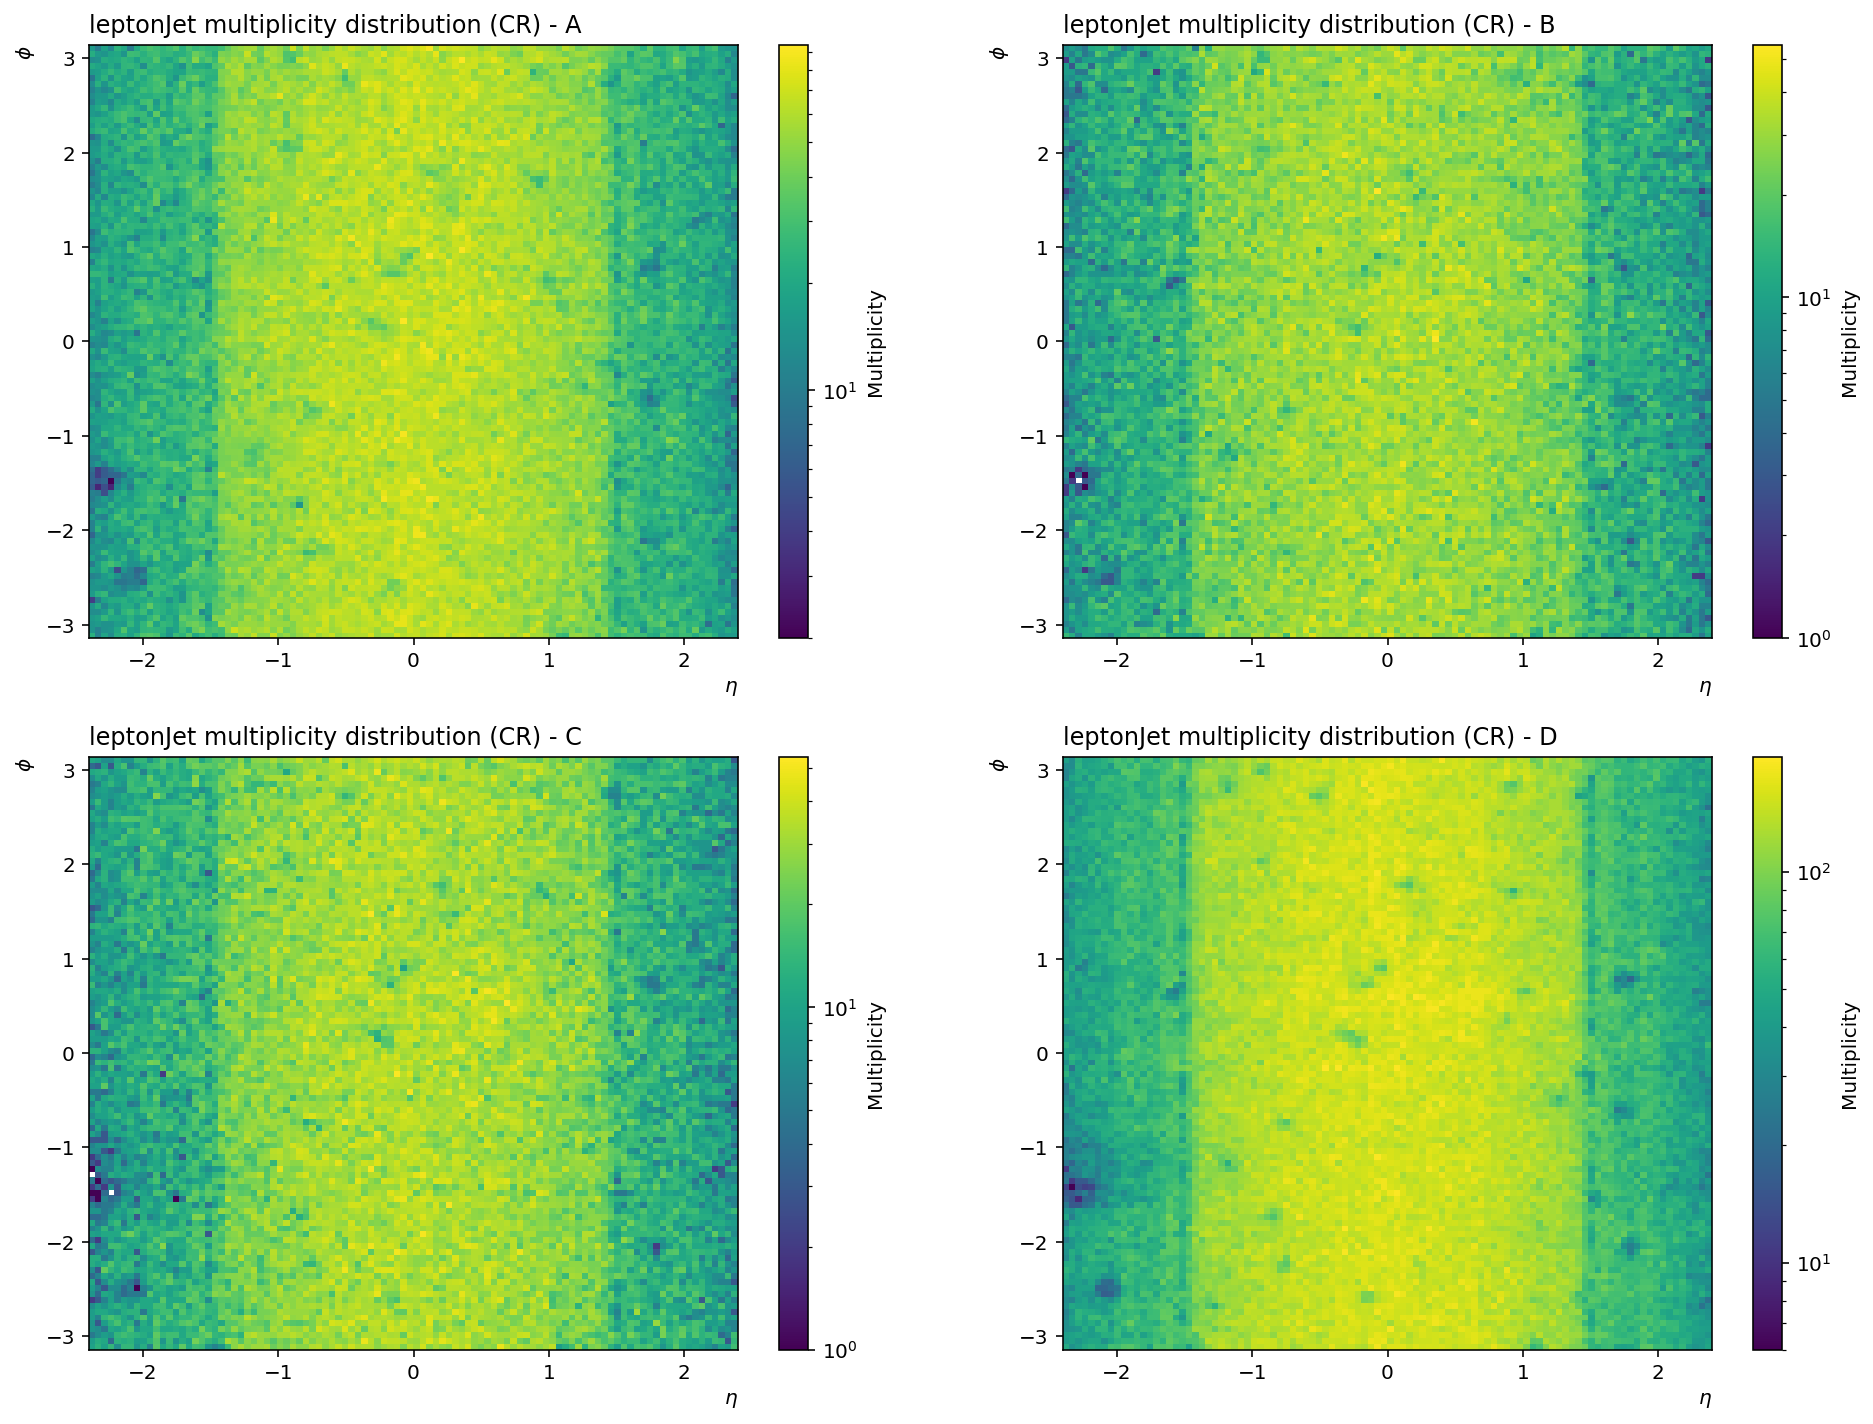

In [9]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['multiplicity'].project('dataset', era), xaxis='eta', ax=axes.flat[i], patch_opts=dict(norm=LogNorm()))

    axes.flat[i].set_title('leptonJet multiplicity distribution (CR) - '+era, x=0.0, ha="left")
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

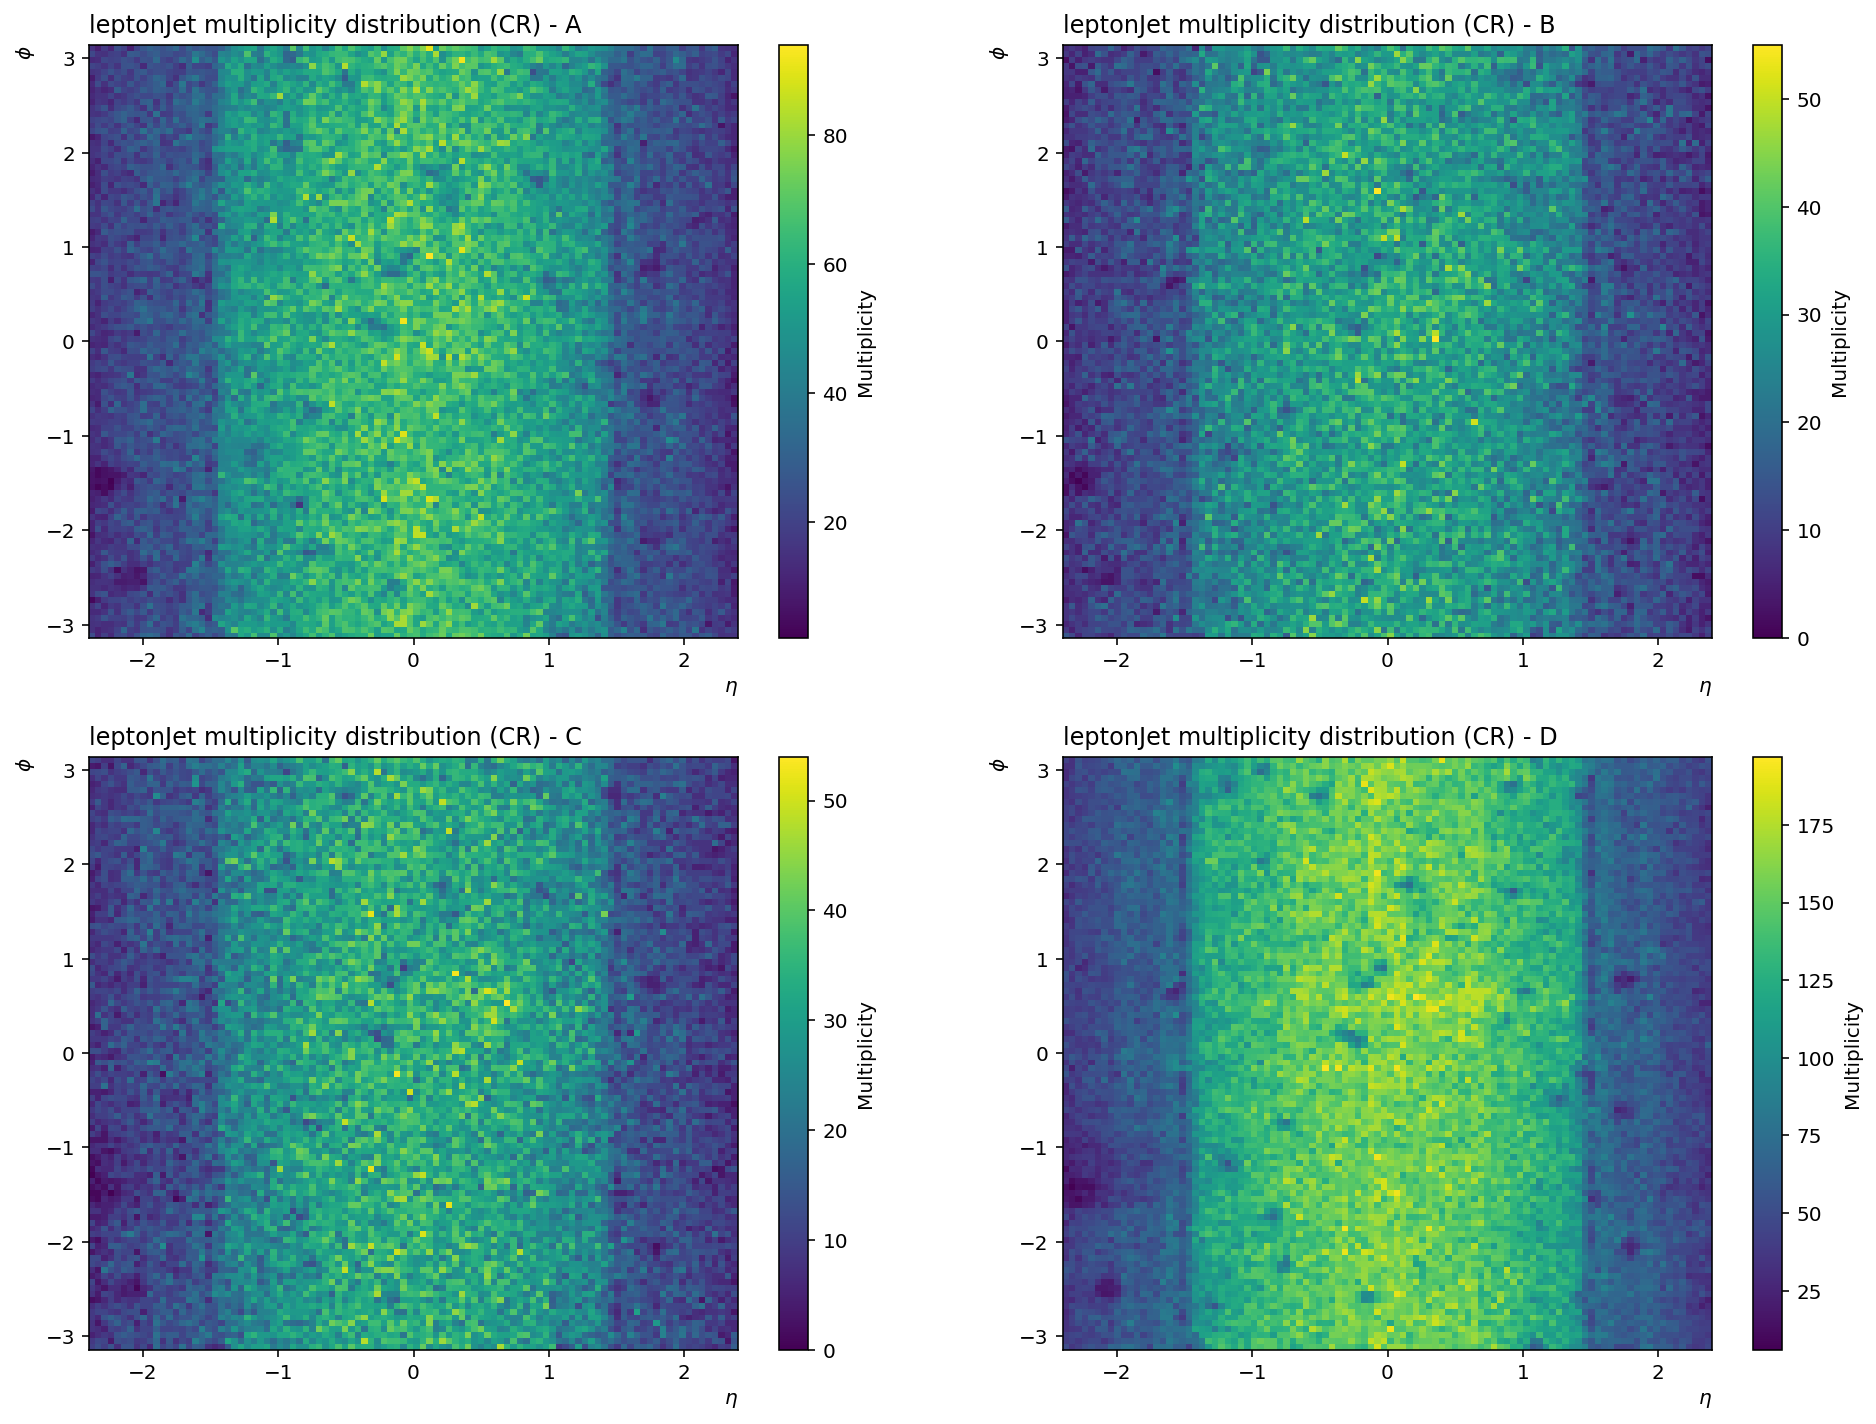

In [10]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['multiplicity'].project('dataset', era), xaxis='eta', ax=axes.flat[i])

    axes.flat[i].set_title('leptonJet multiplicity distribution (CR) - '+era, x=0.0, ha="left")
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

#### leading only

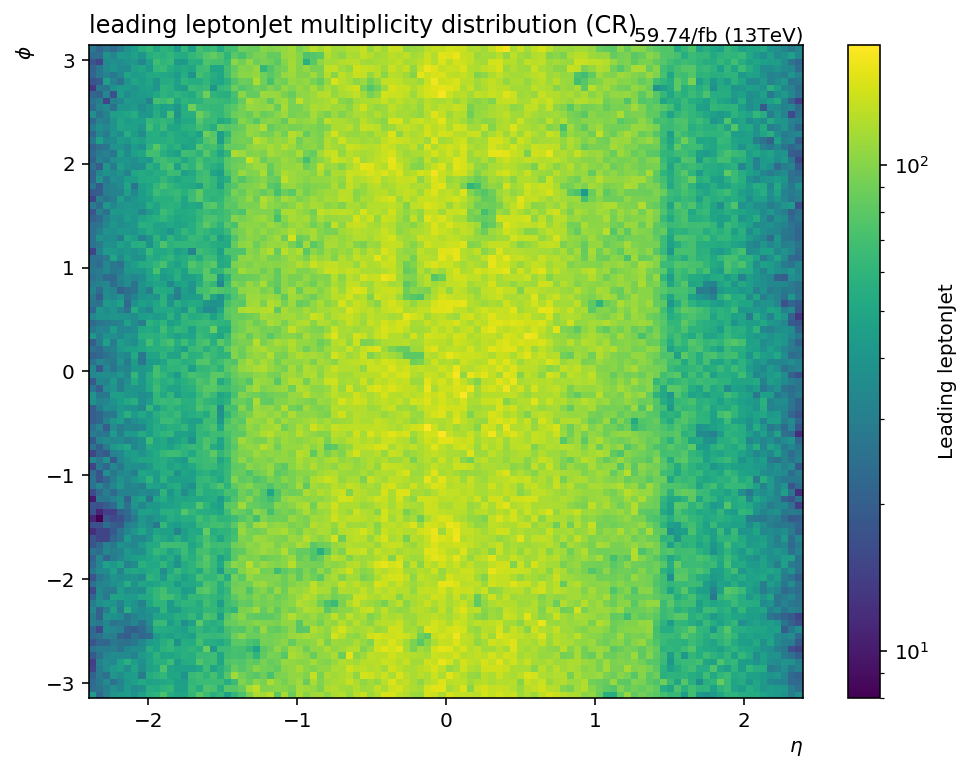

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['leading'].integrate('dataset'), xaxis='eta', ax=ax, patch_opts=dict(norm=LogNorm()))

ax.set_title('leading leptonJet multiplicity distribution (CR)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

split by era

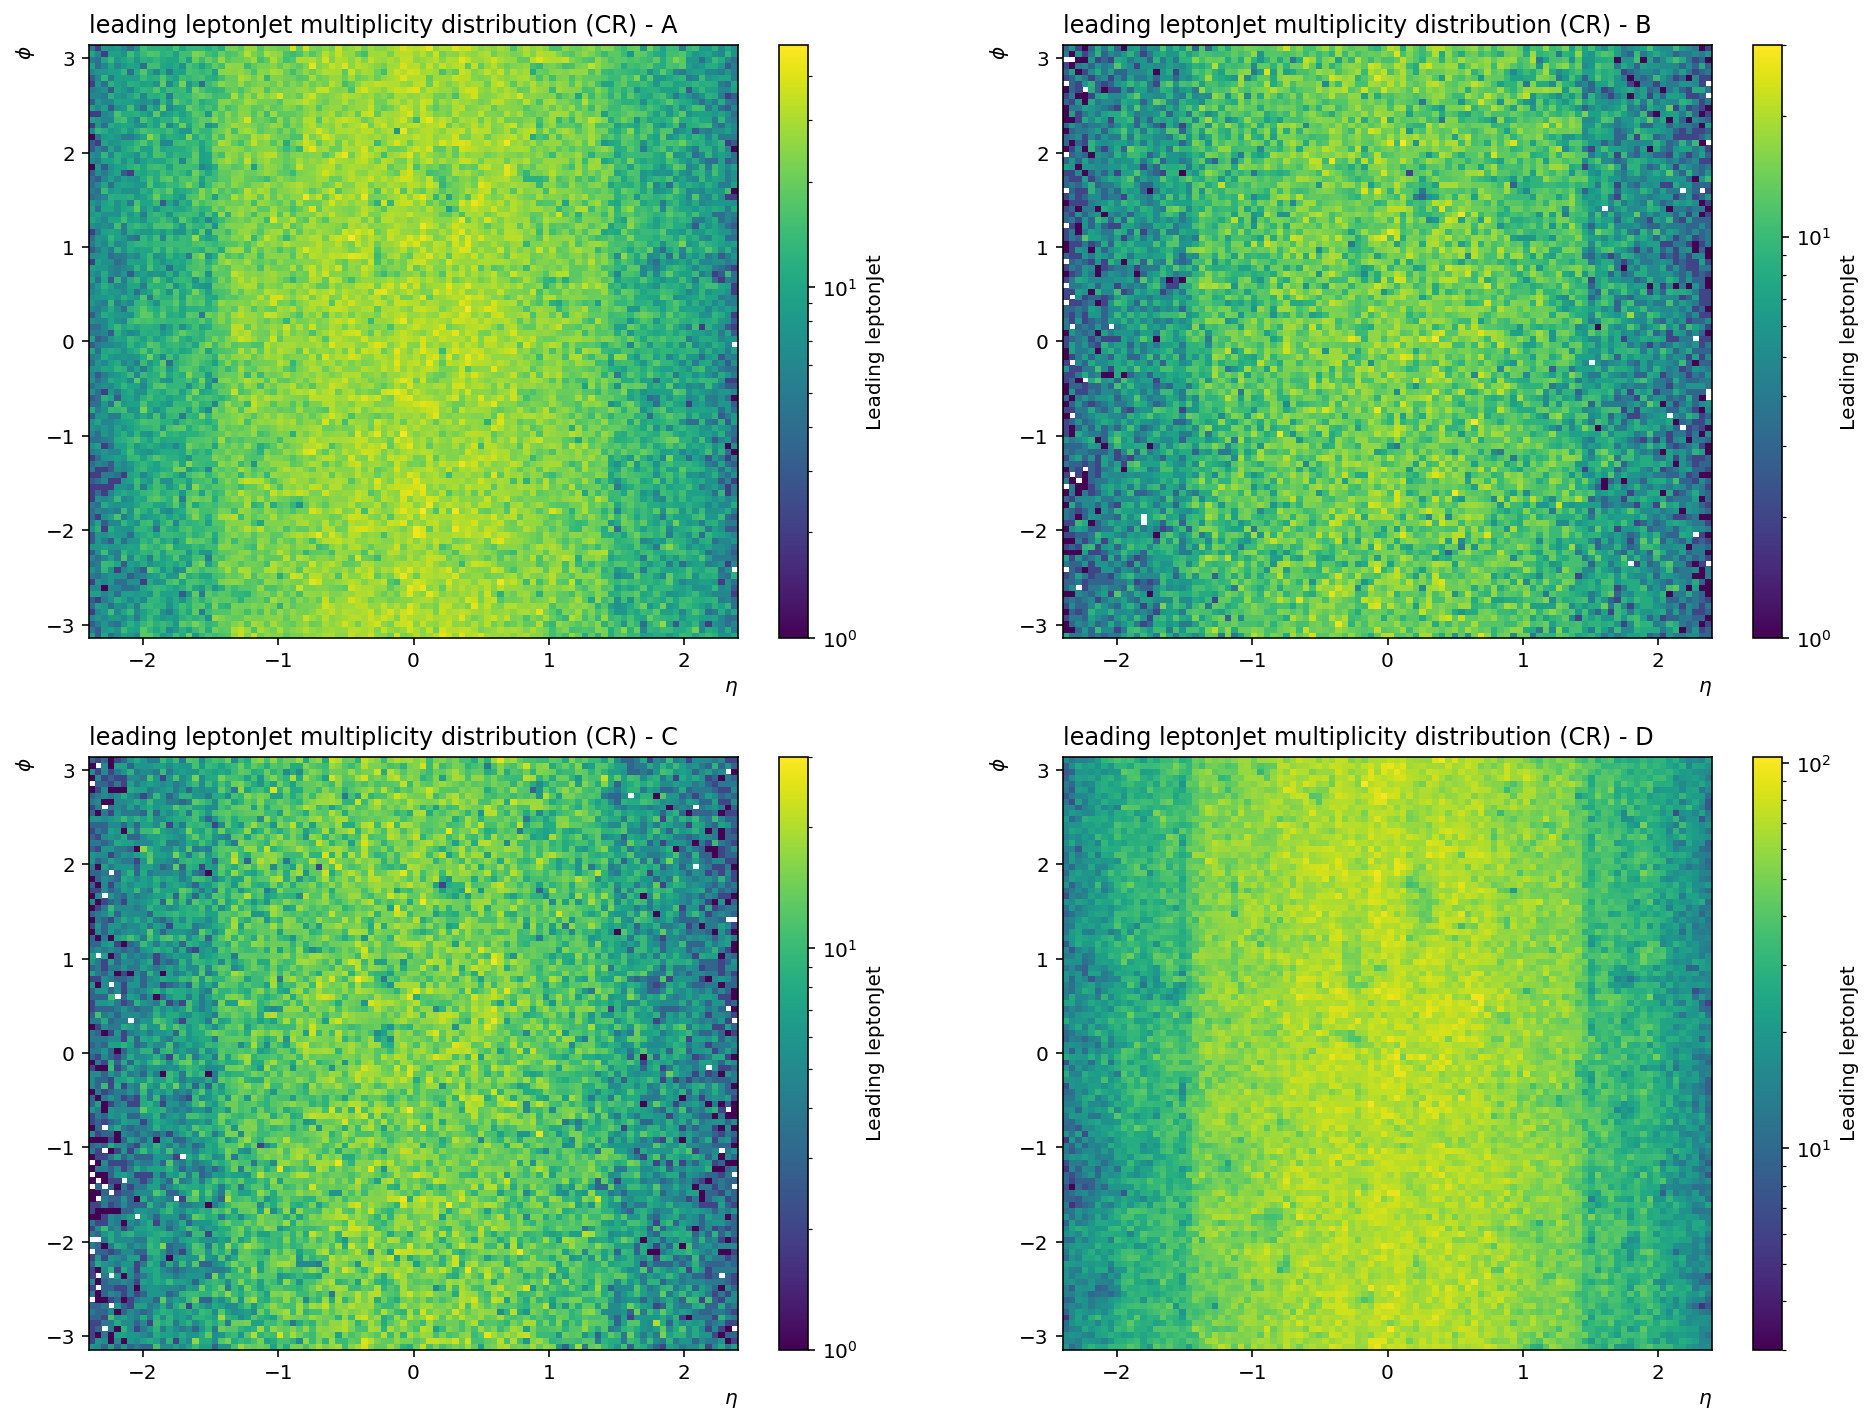

In [11]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['leading'].integrate('dataset', era), xaxis='eta', ax=axes.flat[i], patch_opts=dict(norm=LogNorm()))

    axes.flat[i].set_title('leading leptonJet multiplicity distribution (CR) - '+era, x=0.0, ha="left")
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

#### electron type only

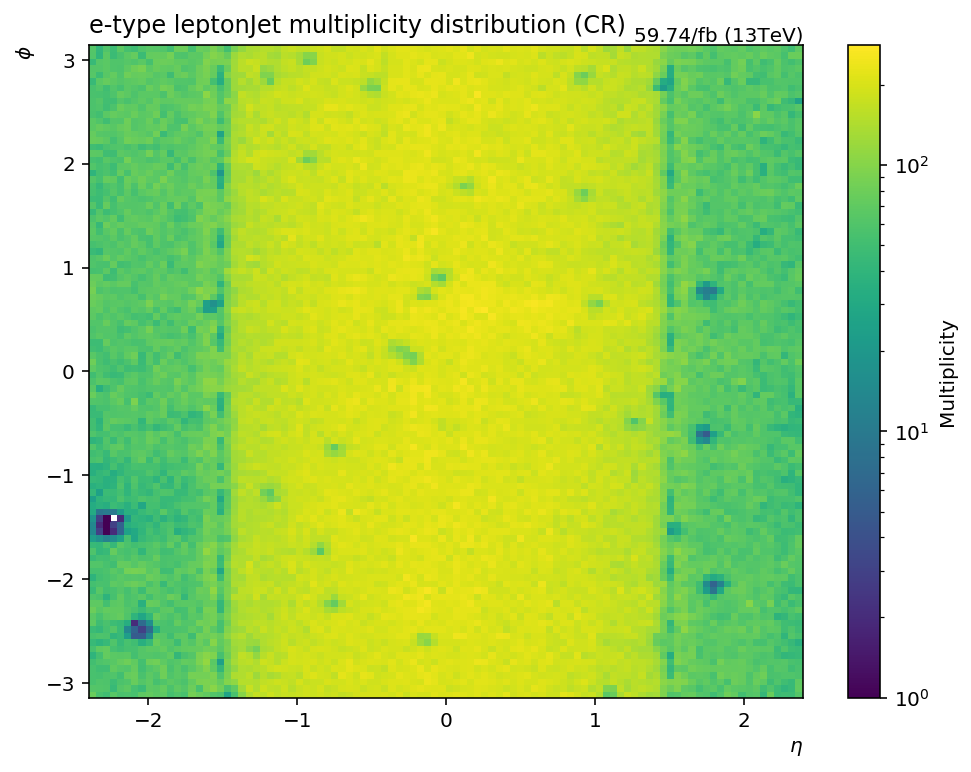

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['electrontype'].integrate('dataset'), xaxis='eta', ax=ax, patch_opts=dict(norm=LogNorm()))

ax.set_title('e-type leptonJet multiplicity distribution (CR)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

split by era

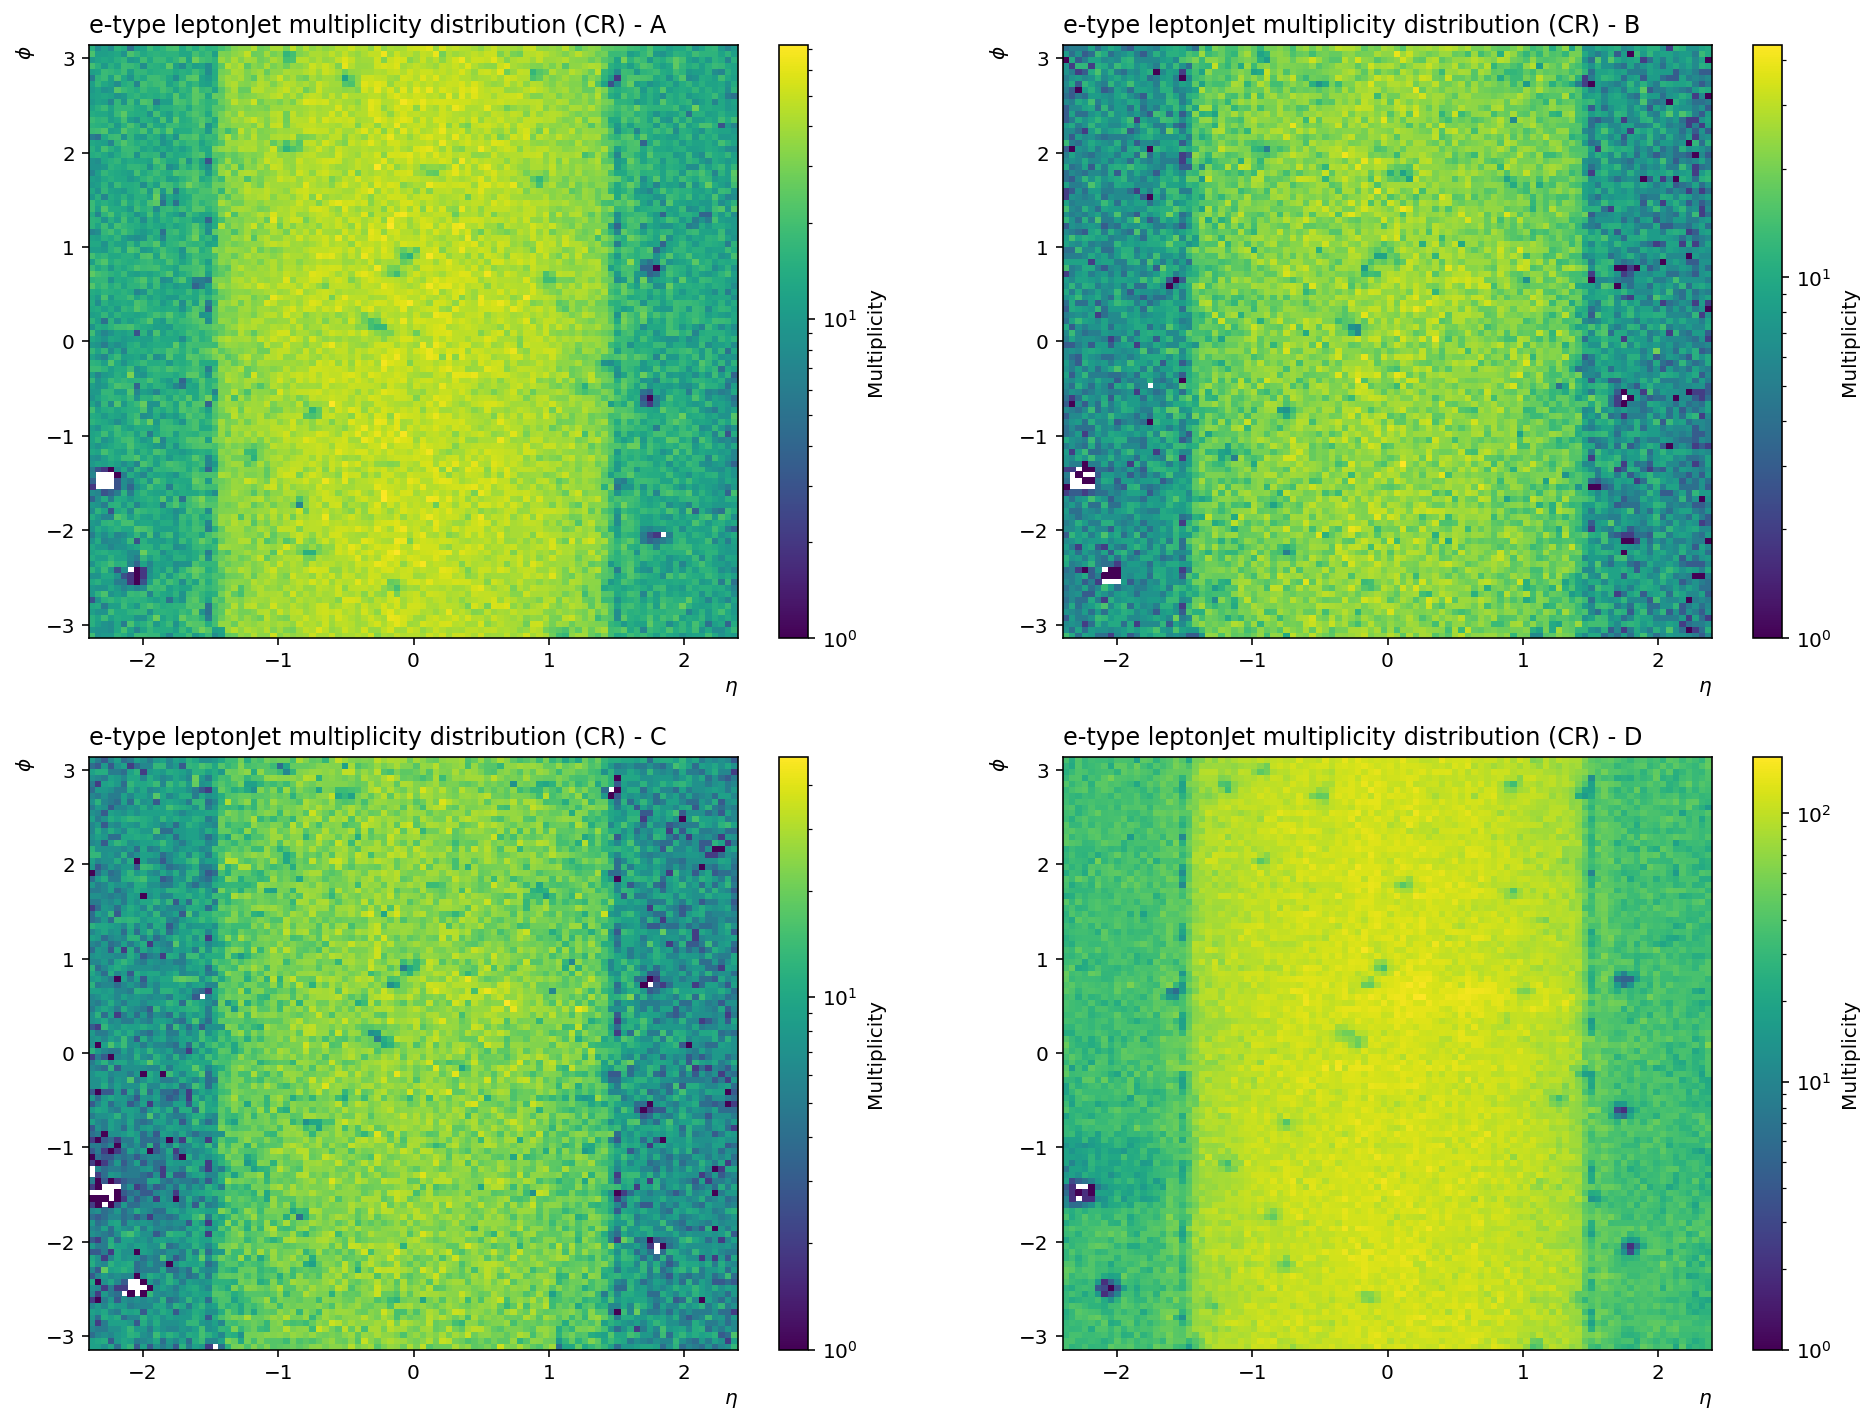

In [14]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['electrontype'].integrate('dataset', era), xaxis='eta', ax=axes.flat[i], patch_opts=dict(norm=LogNorm()))

    axes.flat[i].set_title('e-type leptonJet multiplicity distribution (CR) - '+era, x=0.0, ha="left")
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

#### muon type

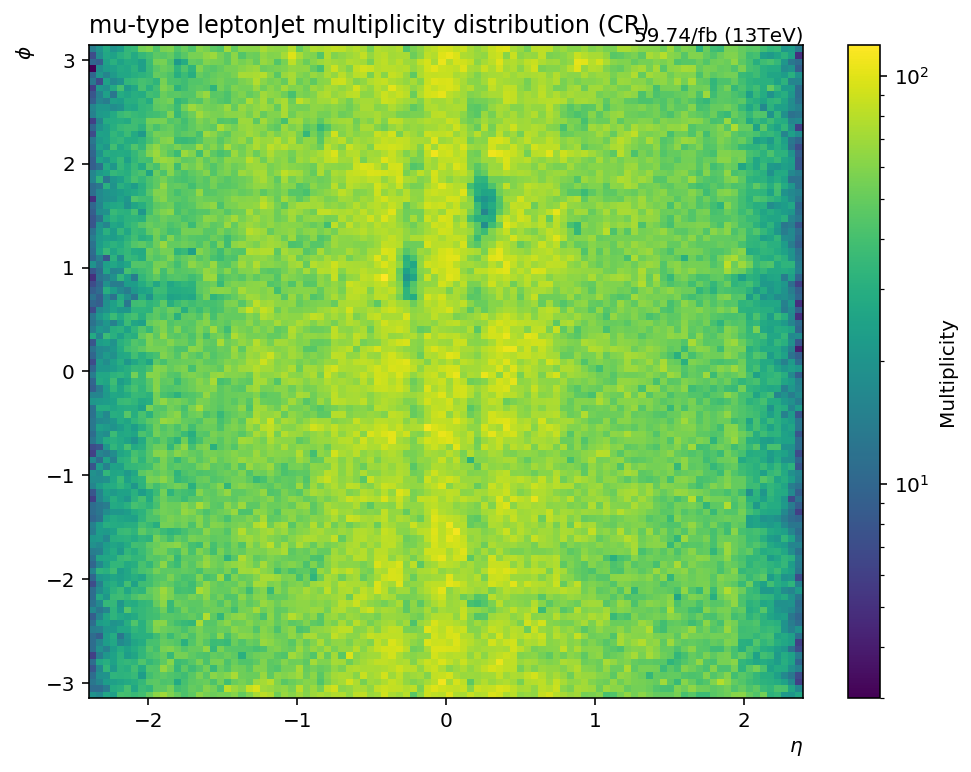

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['mutype'].integrate('dataset'), xaxis='eta', ax=ax, patch_opts=dict(norm=LogNorm()))

ax.set_title('mu-type leptonJet multiplicity distribution (CR)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

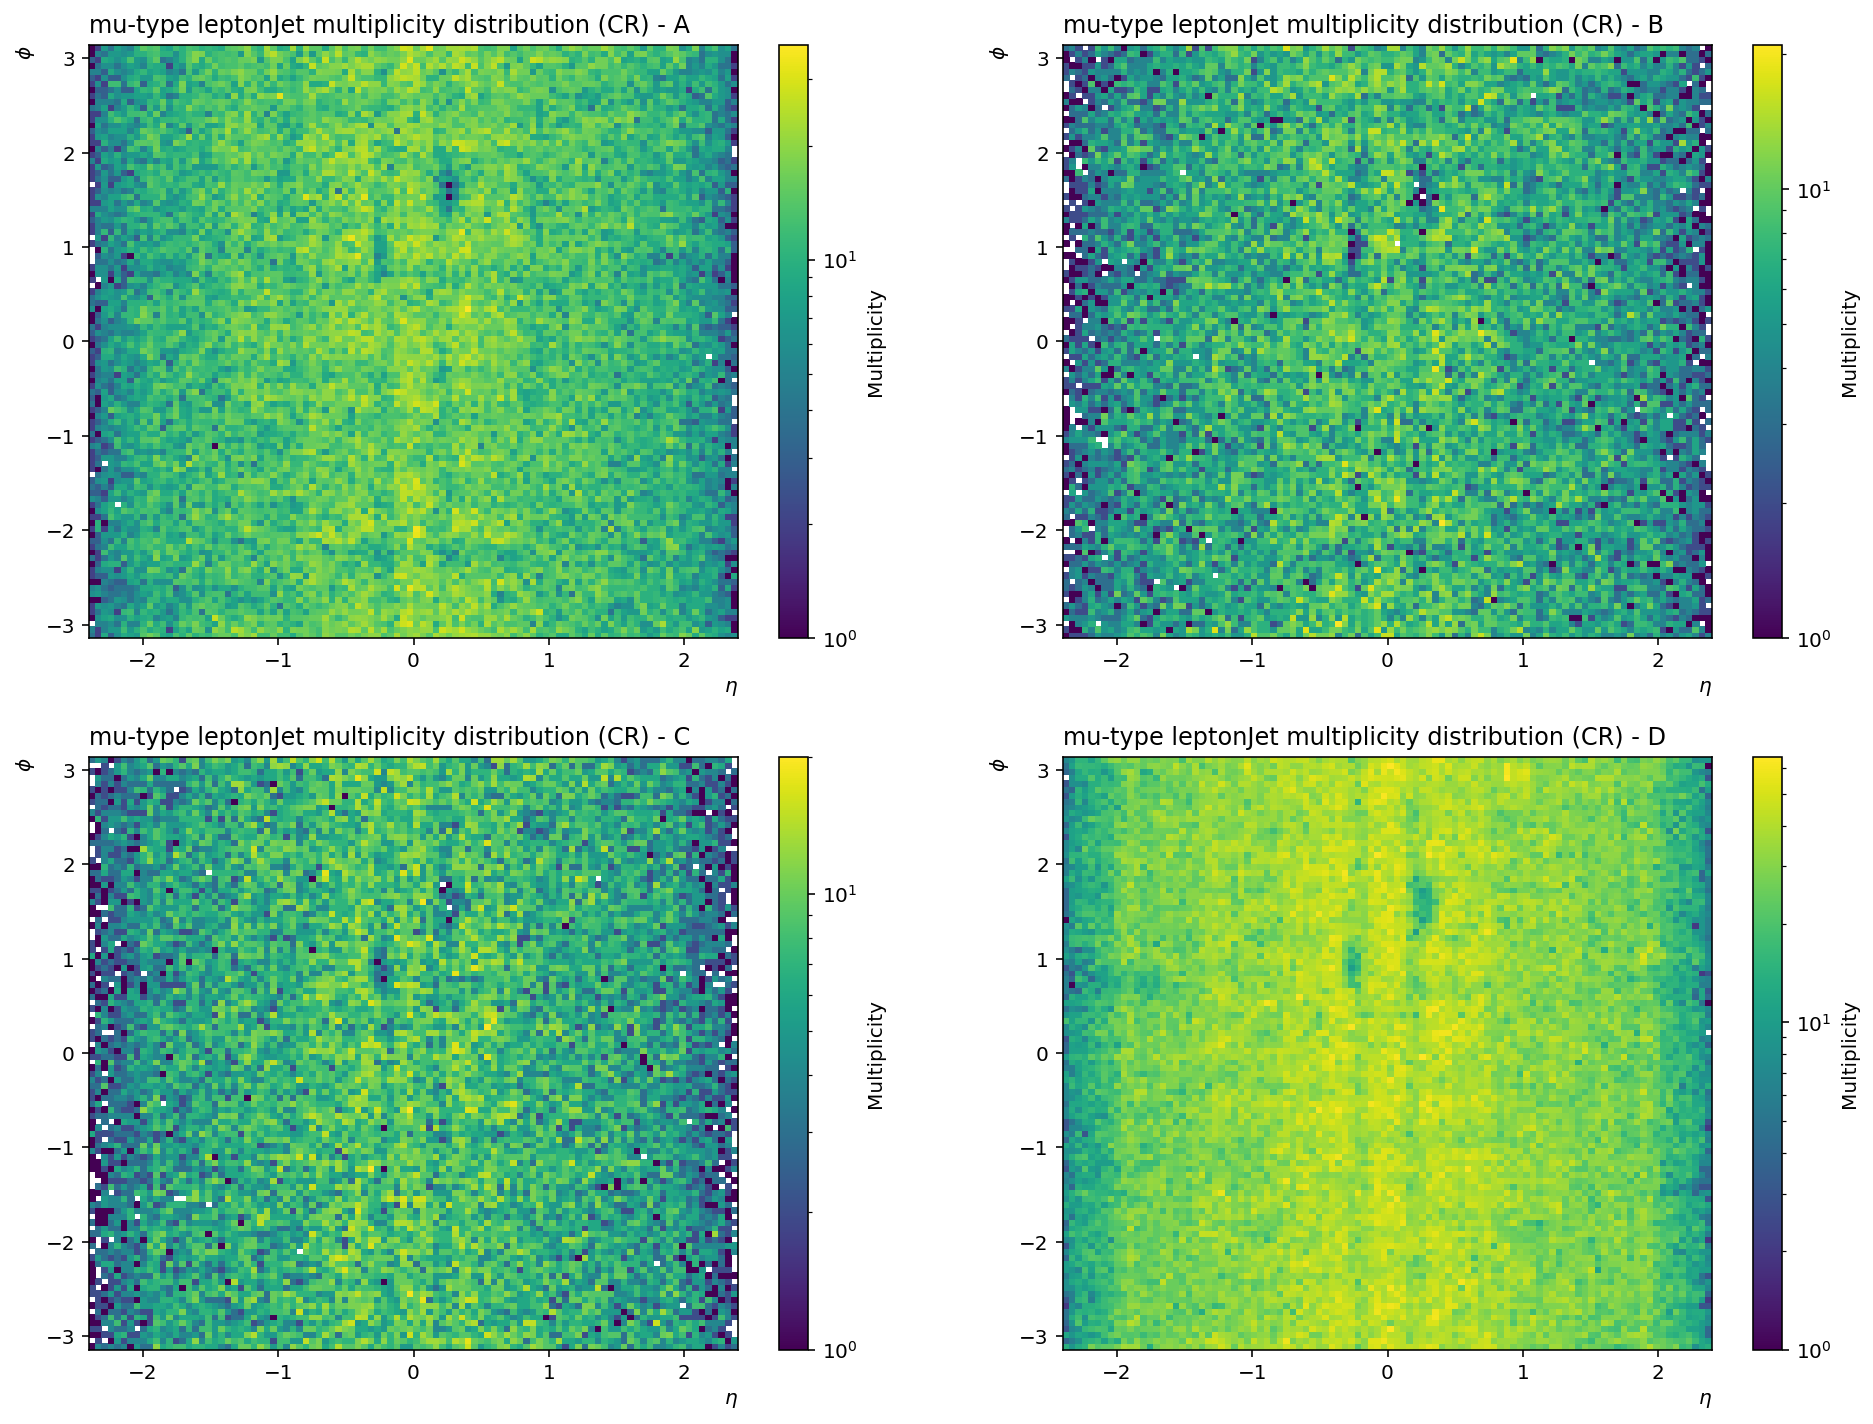

In [18]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['mutype'].integrate('dataset', era), xaxis='eta', ax=axes.flat[i], patch_opts=dict(norm=LogNorm()))

    axes.flat[i].set_title('mu-type leptonJet multiplicity distribution (CR) - '+era, x=0.0, ha="left")
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

#### weighted by energy

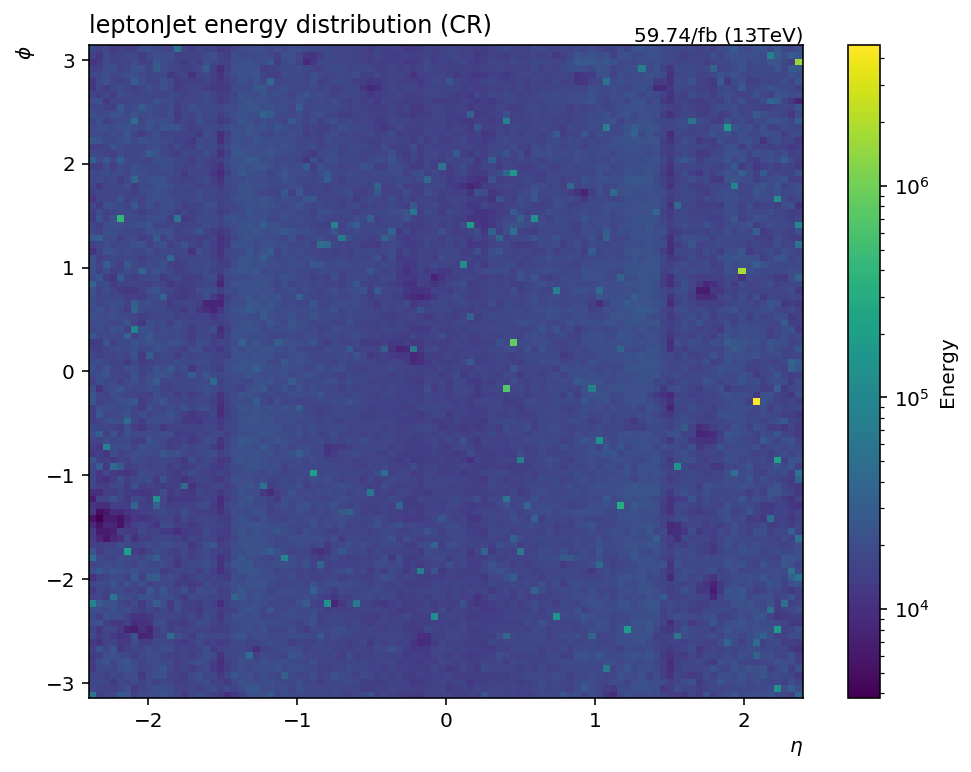

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['energy'].project('dataset'), xaxis='eta', ax=ax, patch_opts=dict(norm=LogNorm()))

ax.set_title('leptonJet energy distribution (CR)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

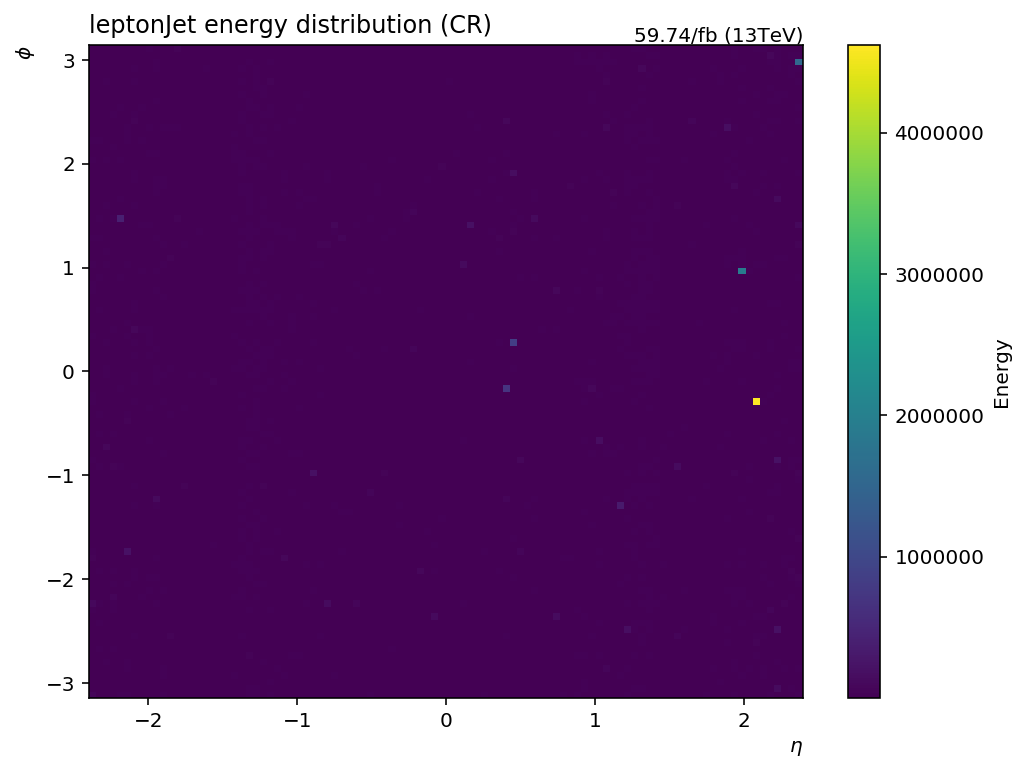

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['energy'].project('dataset'), xaxis='eta', ax=ax,)

ax.set_title('leptonJet energy distribution (CR)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

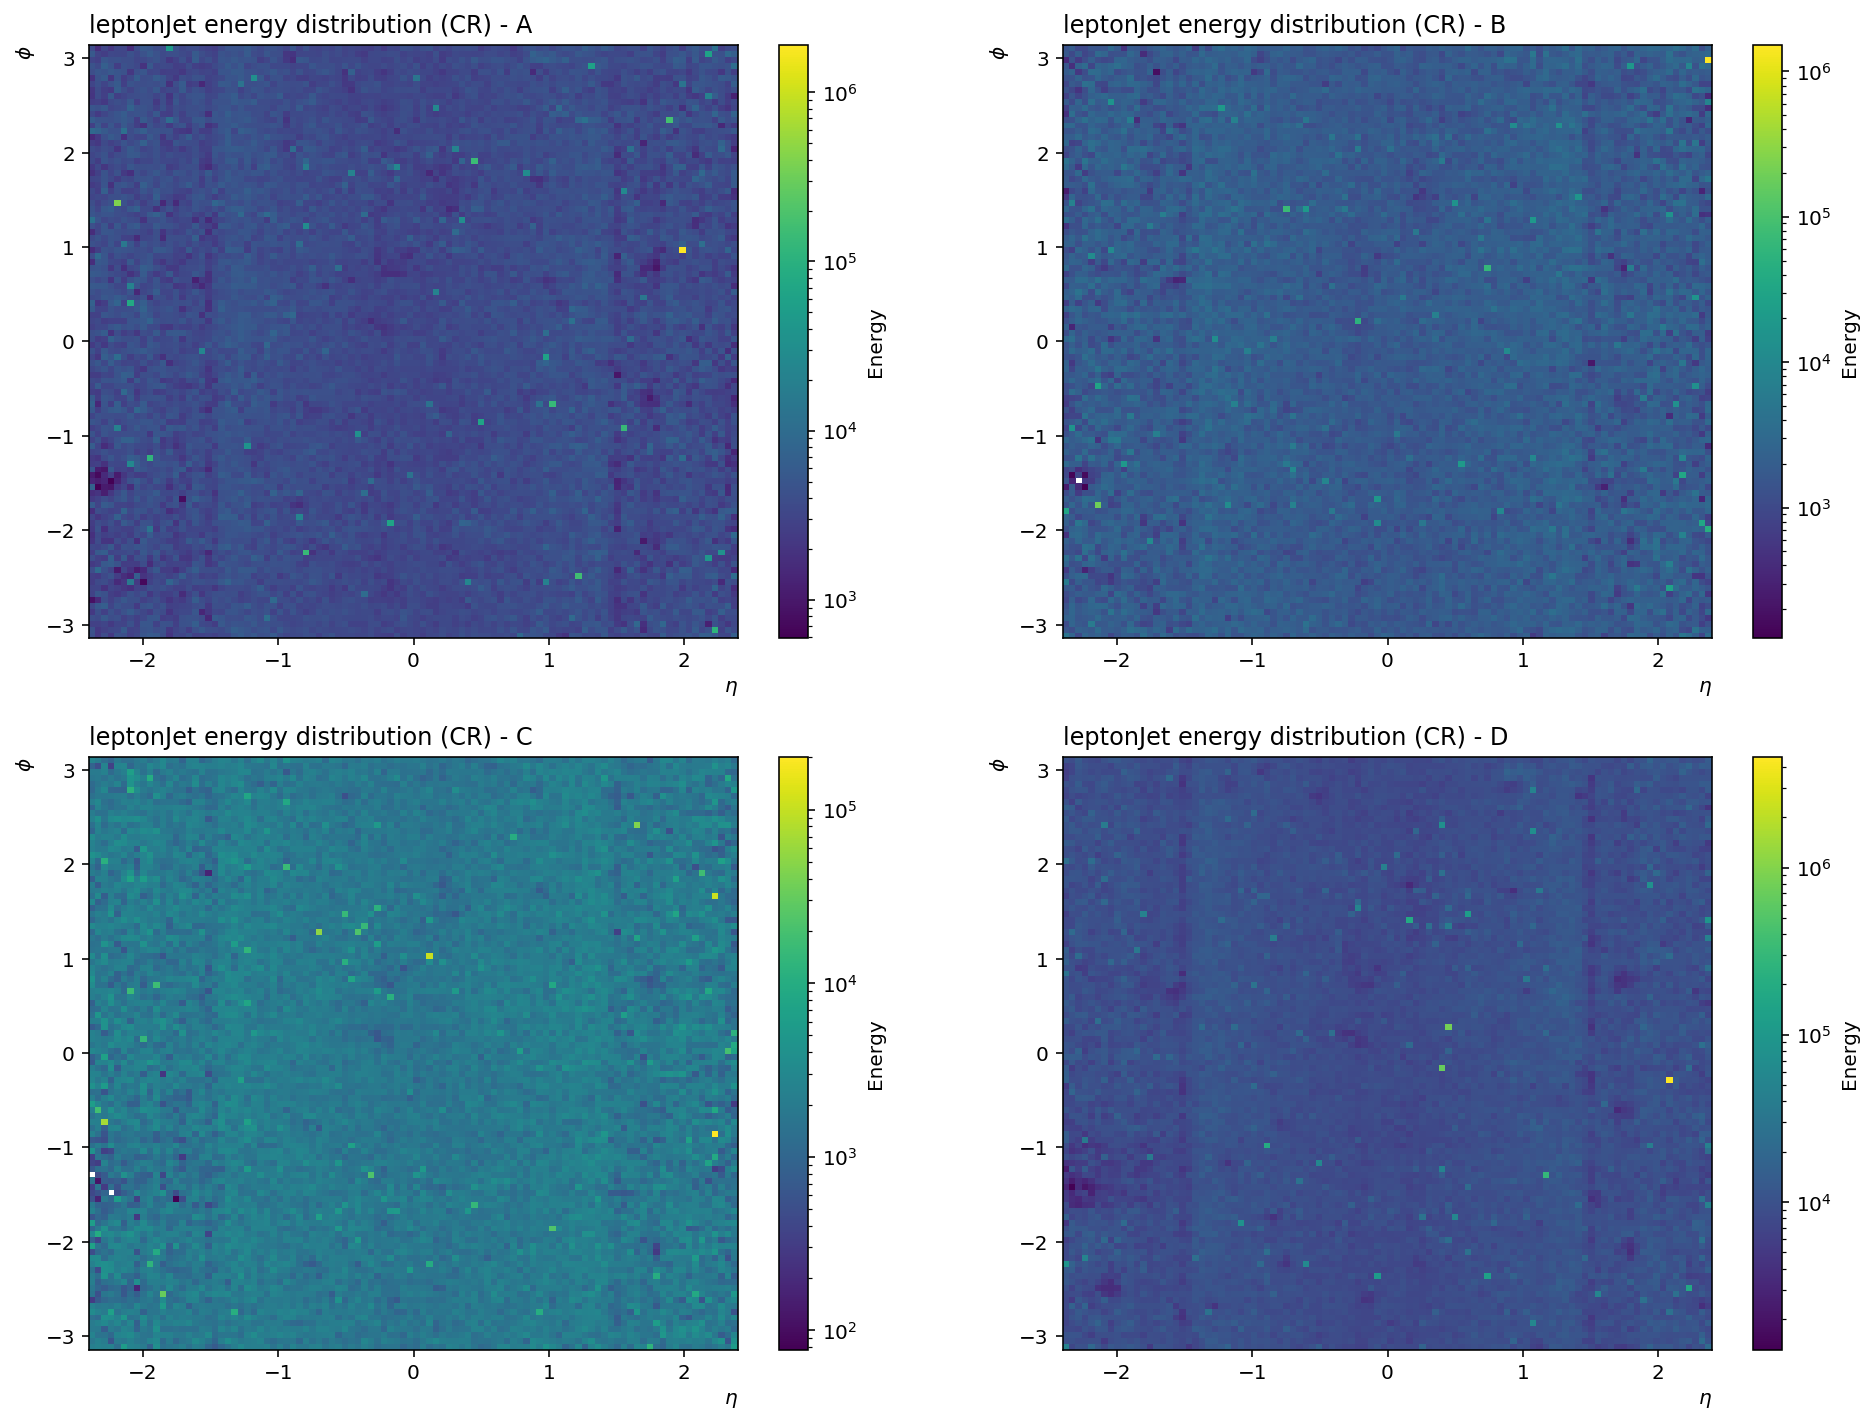

In [21]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['energy'].project('dataset', era), xaxis='eta', ax=axes.flat[i], density=False, patch_opts=dict(norm=LogNorm()))

    axes.flat[i].set_title('leptonJet energy distribution (CR) - '+era, x=0.0, ha="left")
#     axes.flat[i].text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=axes.flat[i].transAxes);
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

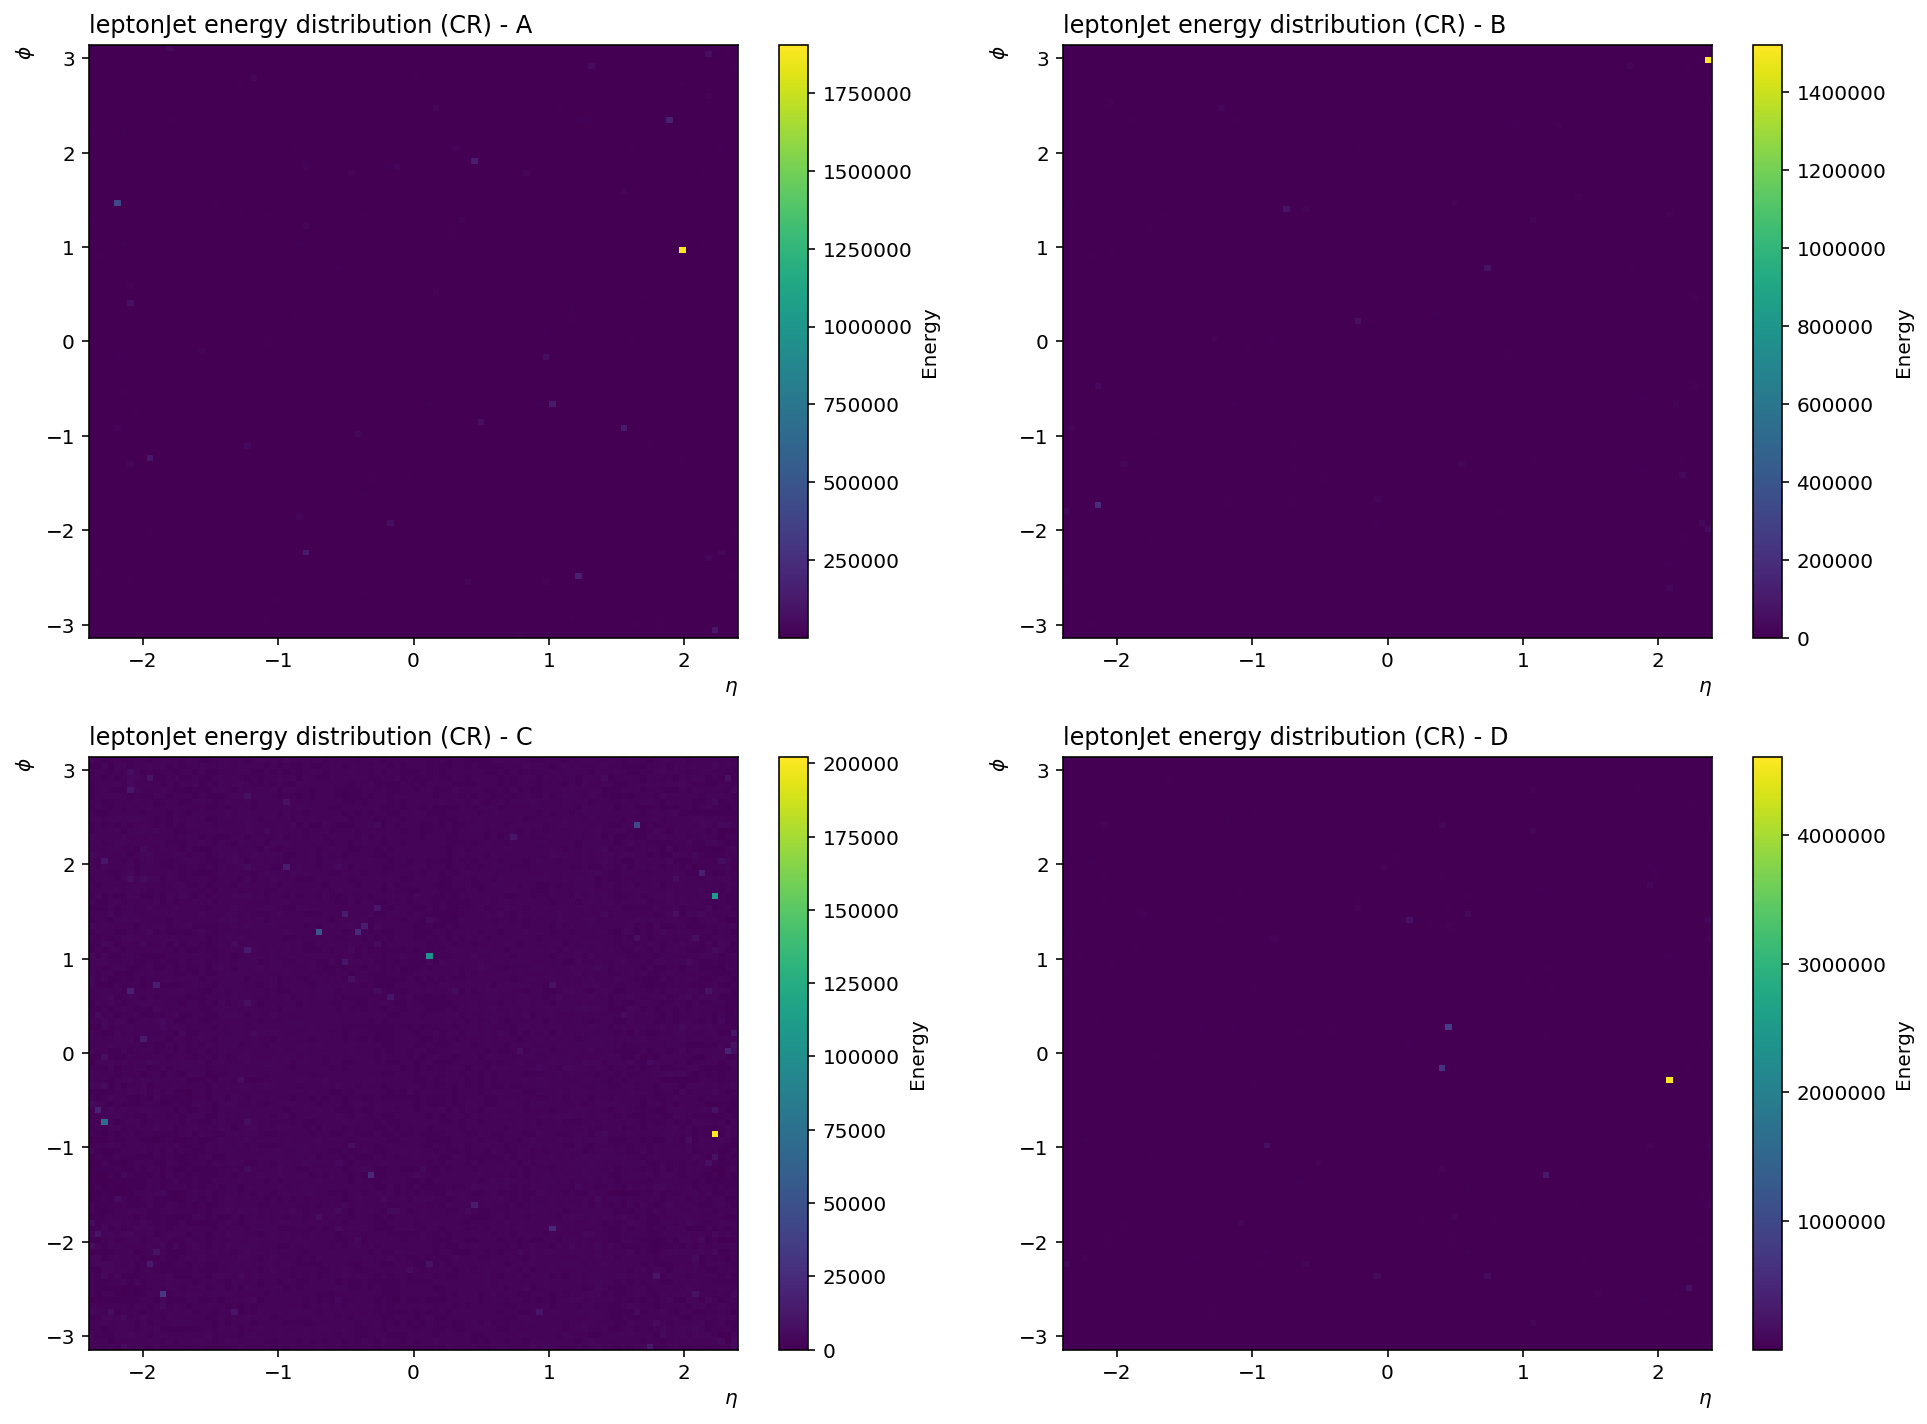

In [7]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['energy'].project('dataset', era), xaxis='eta', ax=axes.flat[i], density=False)

    axes.flat[i].set_title('leptonJet energy distribution (CR) - '+era, x=0.0, ha="left")
#     axes.flat[i].text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=axes.flat[i].transAxes);
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

There are some __hot spots__ observed, it could be some part of detector not working,
but considering they do not have a fixed position, it's more likely some events are being weird (could be events containing cosmic muons).

Look at average leptonJet energy per event.

In [42]:
class leptonJetEnergyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        energy_axis = hist.Bin('avee', 'leptonJet <energy> [GeV]', 1000, 0, 1000)
        
        self._accumulator = processor.dict_accumulator({
            'energy': hist.Hist('#counts', dataset_axis, energy_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset=df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        output['energy'].fill(dataset=dataset, avee=leptonjets.p4.energy.sum()/leptonjets.counts)
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [43]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=leptonJetEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 3017/3017 [01:40<00:00, 29.97items/s]


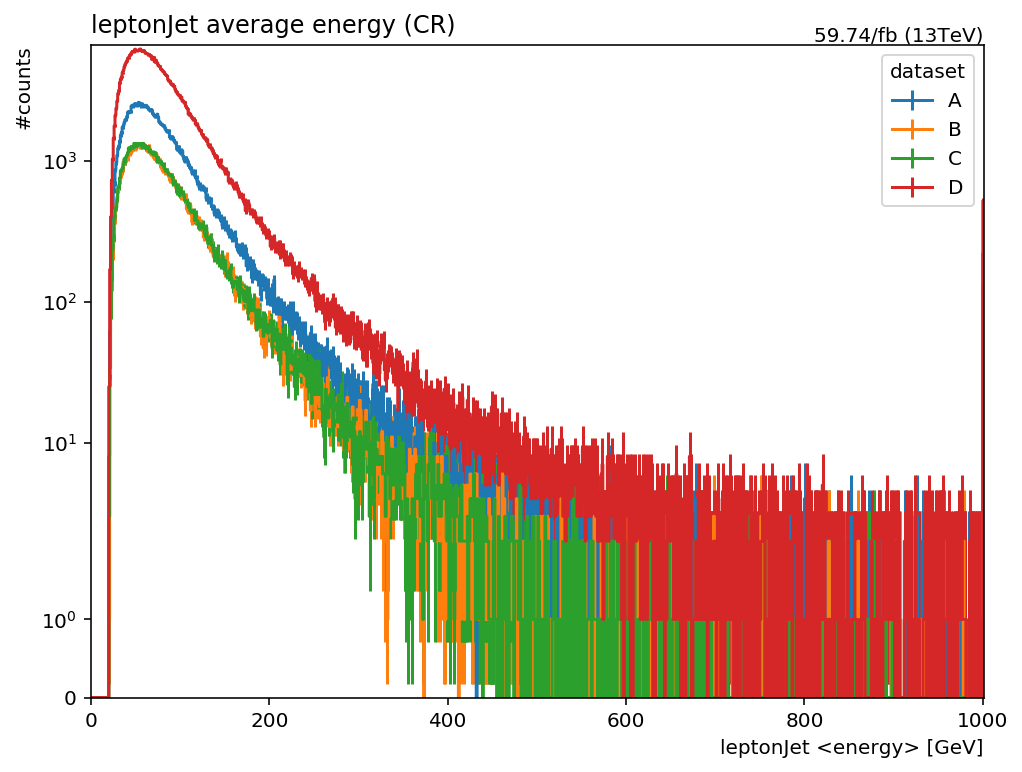

In [44]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot1d(output['energy'], overlay='dataset', ax=ax, overflow='over')

ax.set_yscale('symlog')
ax.set_title('leptonJet average energy (CR)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

collect event whose average energy > 1000
- event_number, eta, phi, energy
- energy distribution

In [5]:
class leptonJetEnergyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        eta_axis = hist.Bin('eta', '$\eta$', 100, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 100, -np.pi, np.pi)
        
        self._accumulator = processor.dict_accumulator({
            'run': processor.column_accumulator(np.zeros(shape=(0,))),
            'lumi': processor.column_accumulator(np.zeros(shape=(0,))),
            'event': processor.column_accumulator(np.zeros(shape=(0,))),
            'counts': processor.column_accumulator(np.zeros(shape=(0,))),
            'eta': processor.column_accumulator(np.zeros(shape=(0,))),
            'phi': processor.column_accumulator(np.zeros(shape=(0,))),
            'energy': processor.column_accumulator(np.zeros(shape=(0,))),
            
            'energymap': hist.Hist('Energy', dataset_axis, eta_axis, phi_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset=df['dataset']
        run = df['run']
        lumi = df['lumi']
        event = df['event']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        avee=leptonjets.p4.energy.sum()/leptonjets.counts
        aveemask = avee>10000
        leptonjets = leptonjets[aveemask]
        
        run = run[metfiltermask][aveemask]
        lumi = lumi[metfiltermask][aveemask]
        event = event[metfiltermask][aveemask]
        
        output['run'] += processor.column_accumulator(run)
        output['lumi'] += processor.column_accumulator(lumi)
        output['event'] += processor.column_accumulator(event)
        
        output['counts'] += processor.column_accumulator(leptonjets.counts)
        output['eta'] += processor.column_accumulator(leptonjets.eta.flatten())
        output['phi'] += processor.column_accumulator(leptonjets.phi.flatten())
        output['energy'] += processor.column_accumulator(leptonjets.p4.energy.flatten())
        
        output['energymap'].fill(dataset=dataset, eta=leptonjets.eta.flatten(),
                                phi=leptonjets.phi.flatten(),
                                weight=leptonjets.p4.energy.flatten())
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [6]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=leptonJetEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 3017/3017 [02:15<00:00, 22.27items/s]


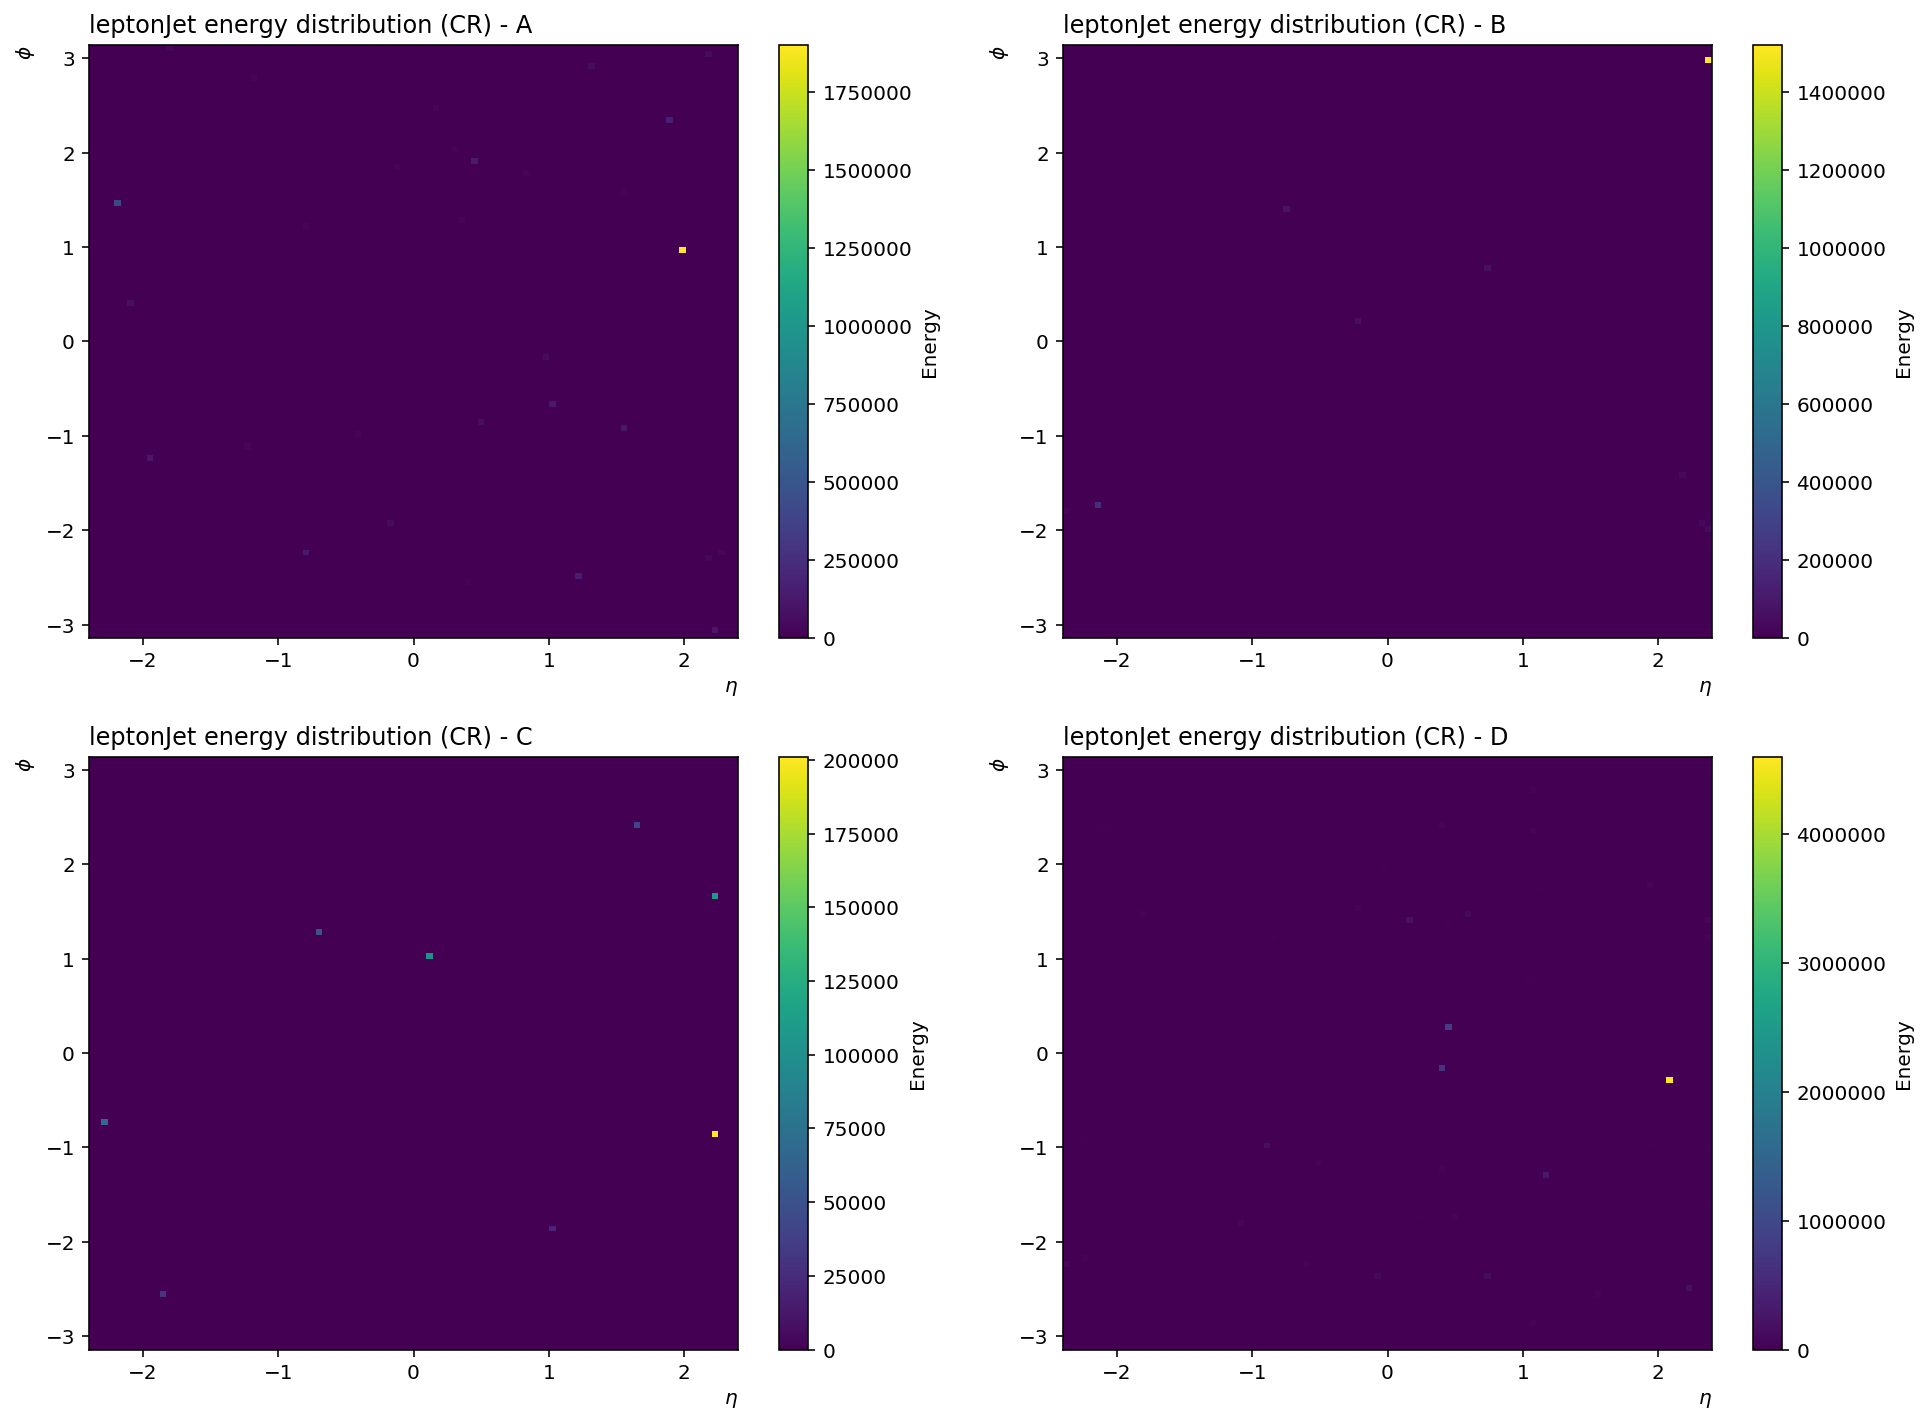

In [10]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['energymap'].project('dataset', era), xaxis='eta', ax=axes.flat[i], density=False)

    axes.flat[i].set_title('leptonJet energy distribution (CR) - '+era, x=0.0, ha="left")
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

In [11]:
output['event'].value.size

86

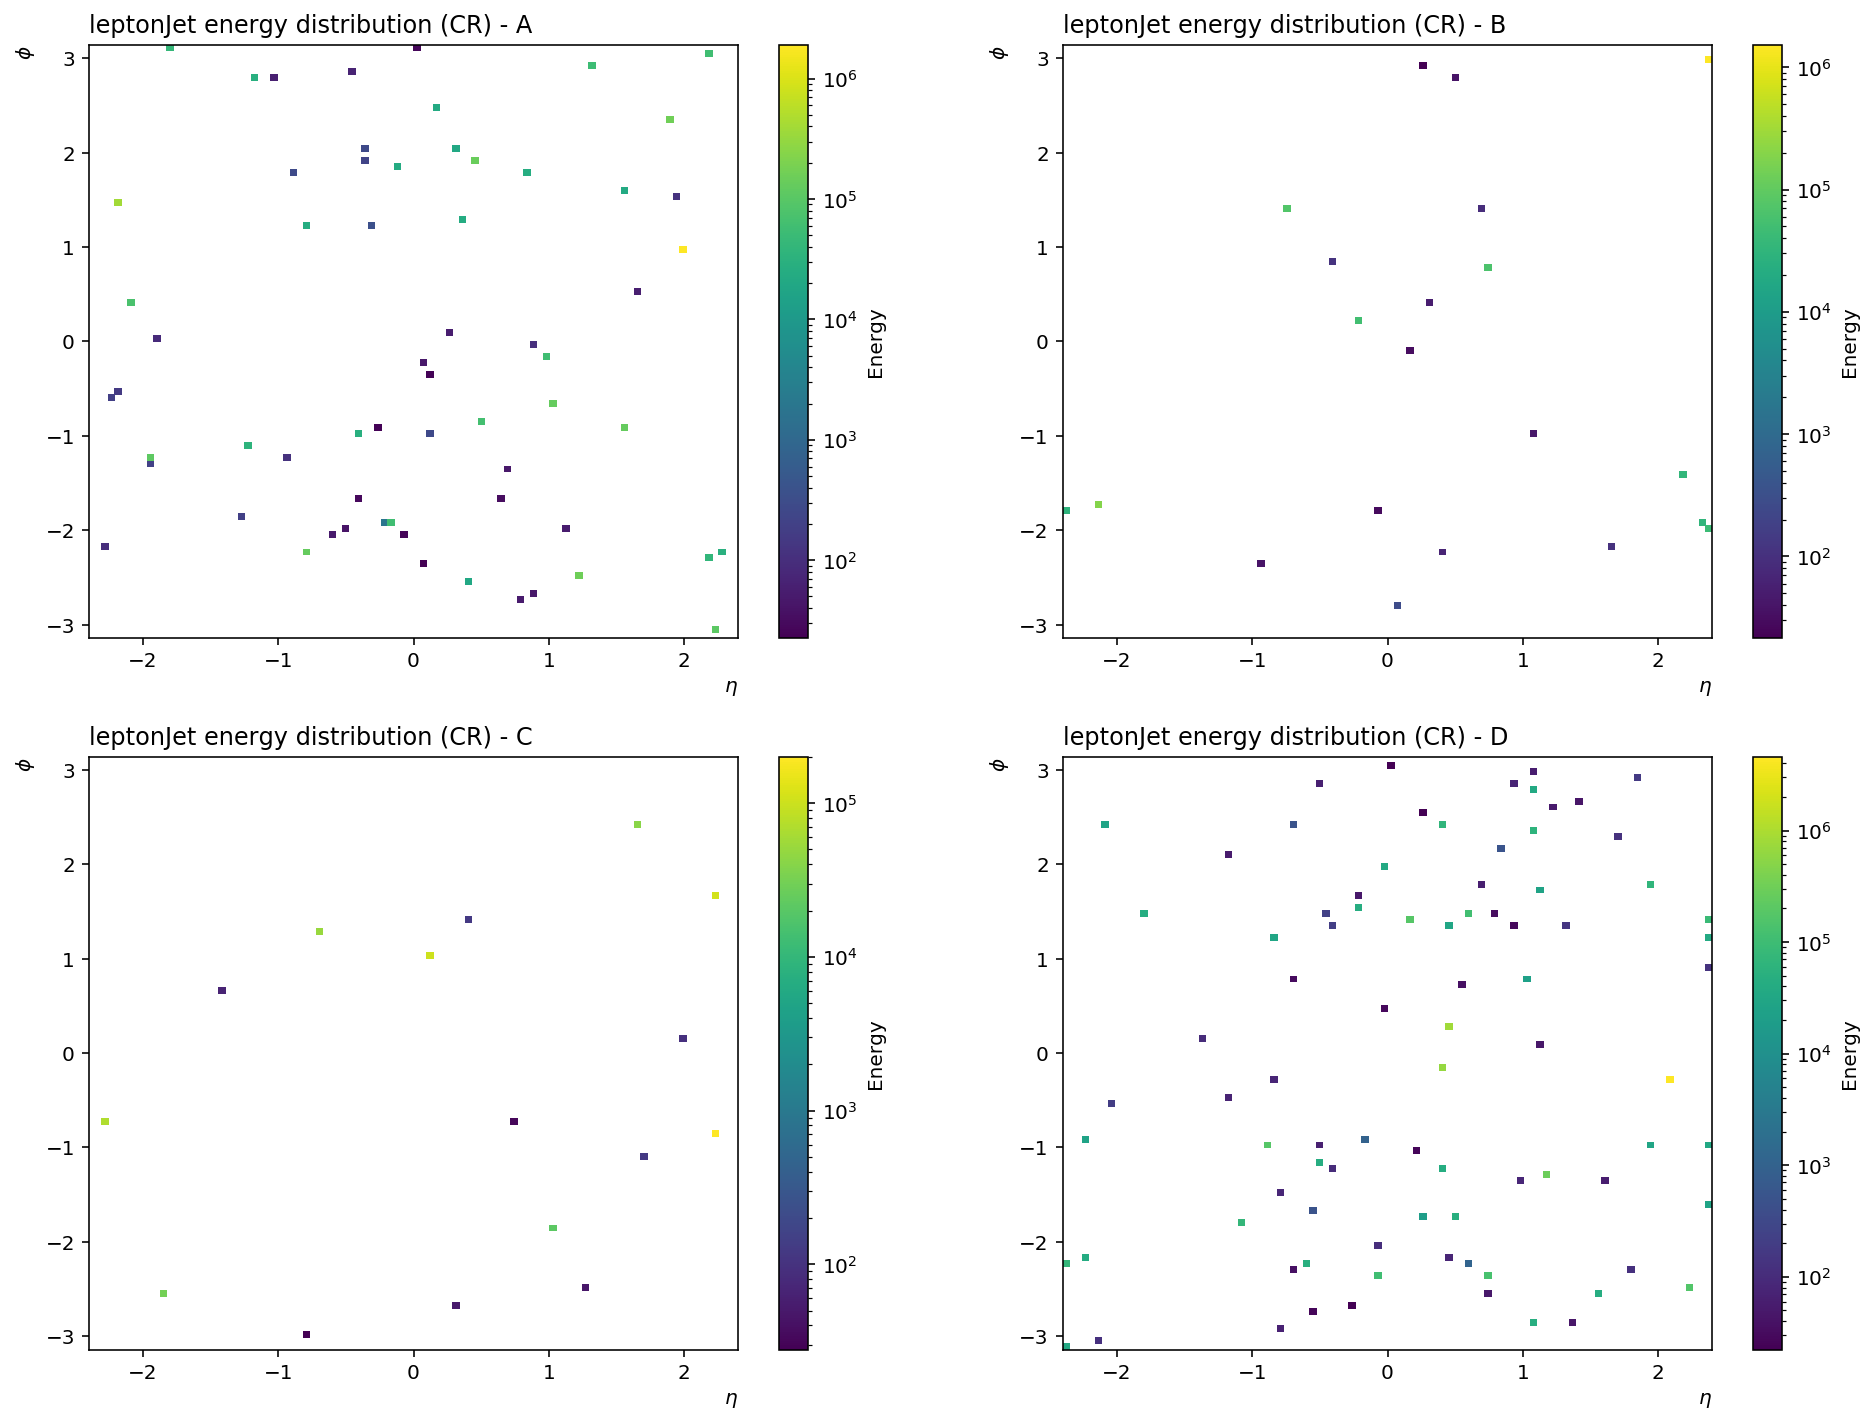

In [12]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['energymap'].project('dataset', era), xaxis='eta', ax=axes.flat[i], density=False, patch_opts=dict(norm=LogNorm()))

    axes.flat[i].set_title('leptonJet energy distribution (CR) - '+era, x=0.0, ha="left")
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

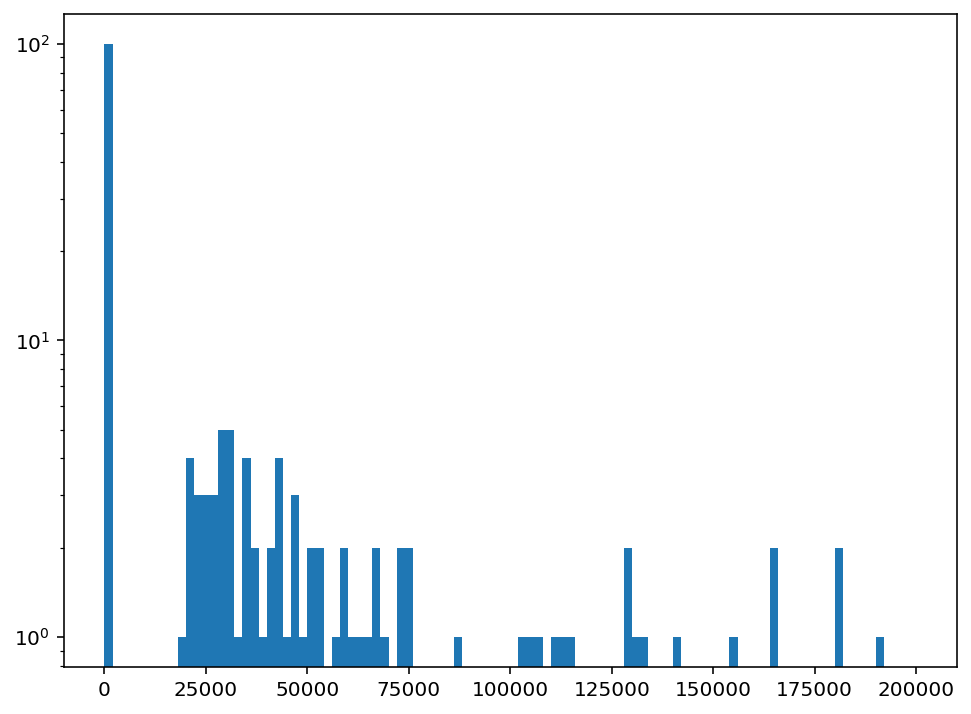

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(output['energy'].value, bins=100, range=[0, 200000])
ax.set_yscale('log')

In [15]:
print(np.sort(output['energy'].value)[-88:])

[1.07113977e+03 1.94968396e+03 1.99598438e+04 2.04201348e+04
 2.05659863e+04 2.11703711e+04 2.18403477e+04 2.25734277e+04
 2.27899023e+04 2.28930605e+04 2.45900449e+04 2.48791309e+04
 2.53342148e+04 2.66175703e+04 2.72010840e+04 2.79271230e+04
 2.87199531e+04 2.87323594e+04 2.88466699e+04 2.90850938e+04
 2.93143281e+04 3.05491602e+04 3.08129277e+04 3.15050625e+04
 3.16164629e+04 3.18177031e+04 3.28764180e+04 3.49971367e+04
 3.50413594e+04 3.56525859e+04 3.59787656e+04 3.67151758e+04
 3.75811641e+04 3.95133398e+04 4.05968633e+04 4.14831562e+04
 4.27991719e+04 4.30432461e+04 4.35025977e+04 4.39983047e+04
 4.48948555e+04 4.60212422e+04 4.65881523e+04 4.77149062e+04
 4.93923750e+04 5.06201602e+04 5.10704414e+04 5.20094180e+04
 5.28428906e+04 5.77722227e+04 5.81179961e+04 5.90055391e+04
 6.02176094e+04 6.29914883e+04 6.51648984e+04 6.64532344e+04
 6.72515000e+04 6.87948906e+04 7.22966719e+04 7.35190625e+04
 7.44653047e+04 7.45120625e+04 8.79037969e+04 1.02267023e+05
 1.05769203e+05 1.078131

In [21]:
from awkward import JaggedArray
energy_ = JaggedArray.fromcounts(output['counts'].value.astype(int), output['energy'].value)
mask = energy_.max()>10000
runs, lumis, events = output['run'].value[mask].astype(int), output['lumi'].value[mask].astype(int), output['event'].value[mask].astype(int)

for r,l,e in np.nditer([runs, lumis, events]):
    print('{}:{}:{}'.format(r, l, e))

316199:456:638569038
316199:46:35540391
315557:202:222332296
315488:260:250443216
316758:1380:1998264559
316758:1083:1542089266
315713:976:1145703808
316457:987:1135142733
315357:118:87957055
316766:877:1192633241
316590:433:588925175
315361:203:171885587
316218:859:1194219475
315713:76:78187604
315721:153:203534752
316766:1333:1843404323
316469:286:363028276
316457:235:291862988
316380:1182:1028145412
315488:614:575429511
316716:174:219960572
316457:217:273956207
316666:354:490541263
315703:61:68232135
316615:81:51251112
315703:188:208548841
316615:240:145064394
316721:6:8323217
315784:102:120428637
316469:75:84639230
317626:519:767319972
317484:129:155704375
317661:747:1110580215
317527:884:1248712151
317527:1031:1468380393
317340:104:135250641
317640:416:578254197
317640:66:74291501
317392:114:162529194
319910:237:397835302
319941:124:157924706
319993:811:1274034335
320040:14:21761005
319579:2505:3896608248
320040:733:1141538000
319347:384:503412878
319503:203:309793621
322430:361:5

In [66]:
print('-'*50)
print('{:>14} | leptonjet energy'.format('event'))
print('-'*50)
for e, v in zip(output['event'].value[energy_.mean()>100000], energy_[energy_.mean()>100000]):
    print('{:>14} | {}'.format(int(e), v))
print('-'*50)

--------------------------------------------------
         event | leptonjet energy
--------------------------------------------------
      51251112 | [4.01249906e+05 2.77471104e+01 2.45542545e+01]
     208548841 | [1.9008100e+06 6.0425869e+01]
    1110580215 | [1.52102500e+06 3.90654831e+01]
     503412878 | [2.01123219e+05 9.65621414e+01]
     235832903 | [6.72596375e+05 4.87984085e+01]
     779164516 | [2.94895188e+05 7.43577042e+01]
     122238992 | [4.59837100e+06 5.34767036e+01 3.72446404e+01]
     125603326 | [8.21522188e+05 5.13096046e+01]
--------------------------------------------------


Now we intentionally mask these events

In [22]:
suspiciousevents = events

class leptonJetEnergyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        eta_axis = hist.Bin('eta', '$\eta$', 100, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 100, -np.pi, np.pi)
        
        self._accumulator = processor.dict_accumulator({
            'energy': hist.Hist('Energy', dataset_axis, eta_axis, phi_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset=df['dataset']
        event=df['event']
        eventmask = np.logical_and.reduce([event!=e for e in suspiciousevents])
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[eventmask&metfiltermask]
        
        output['energy'].fill(dataset=dataset, eta=leptonjets.eta.flatten(),
                             phi=leptonjets.phi.flatten(),
                             weight=leptonjets.p4.energy.flatten())
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [23]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=leptonJetEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 3017/3017 [01:49<00:00, 27.45items/s]


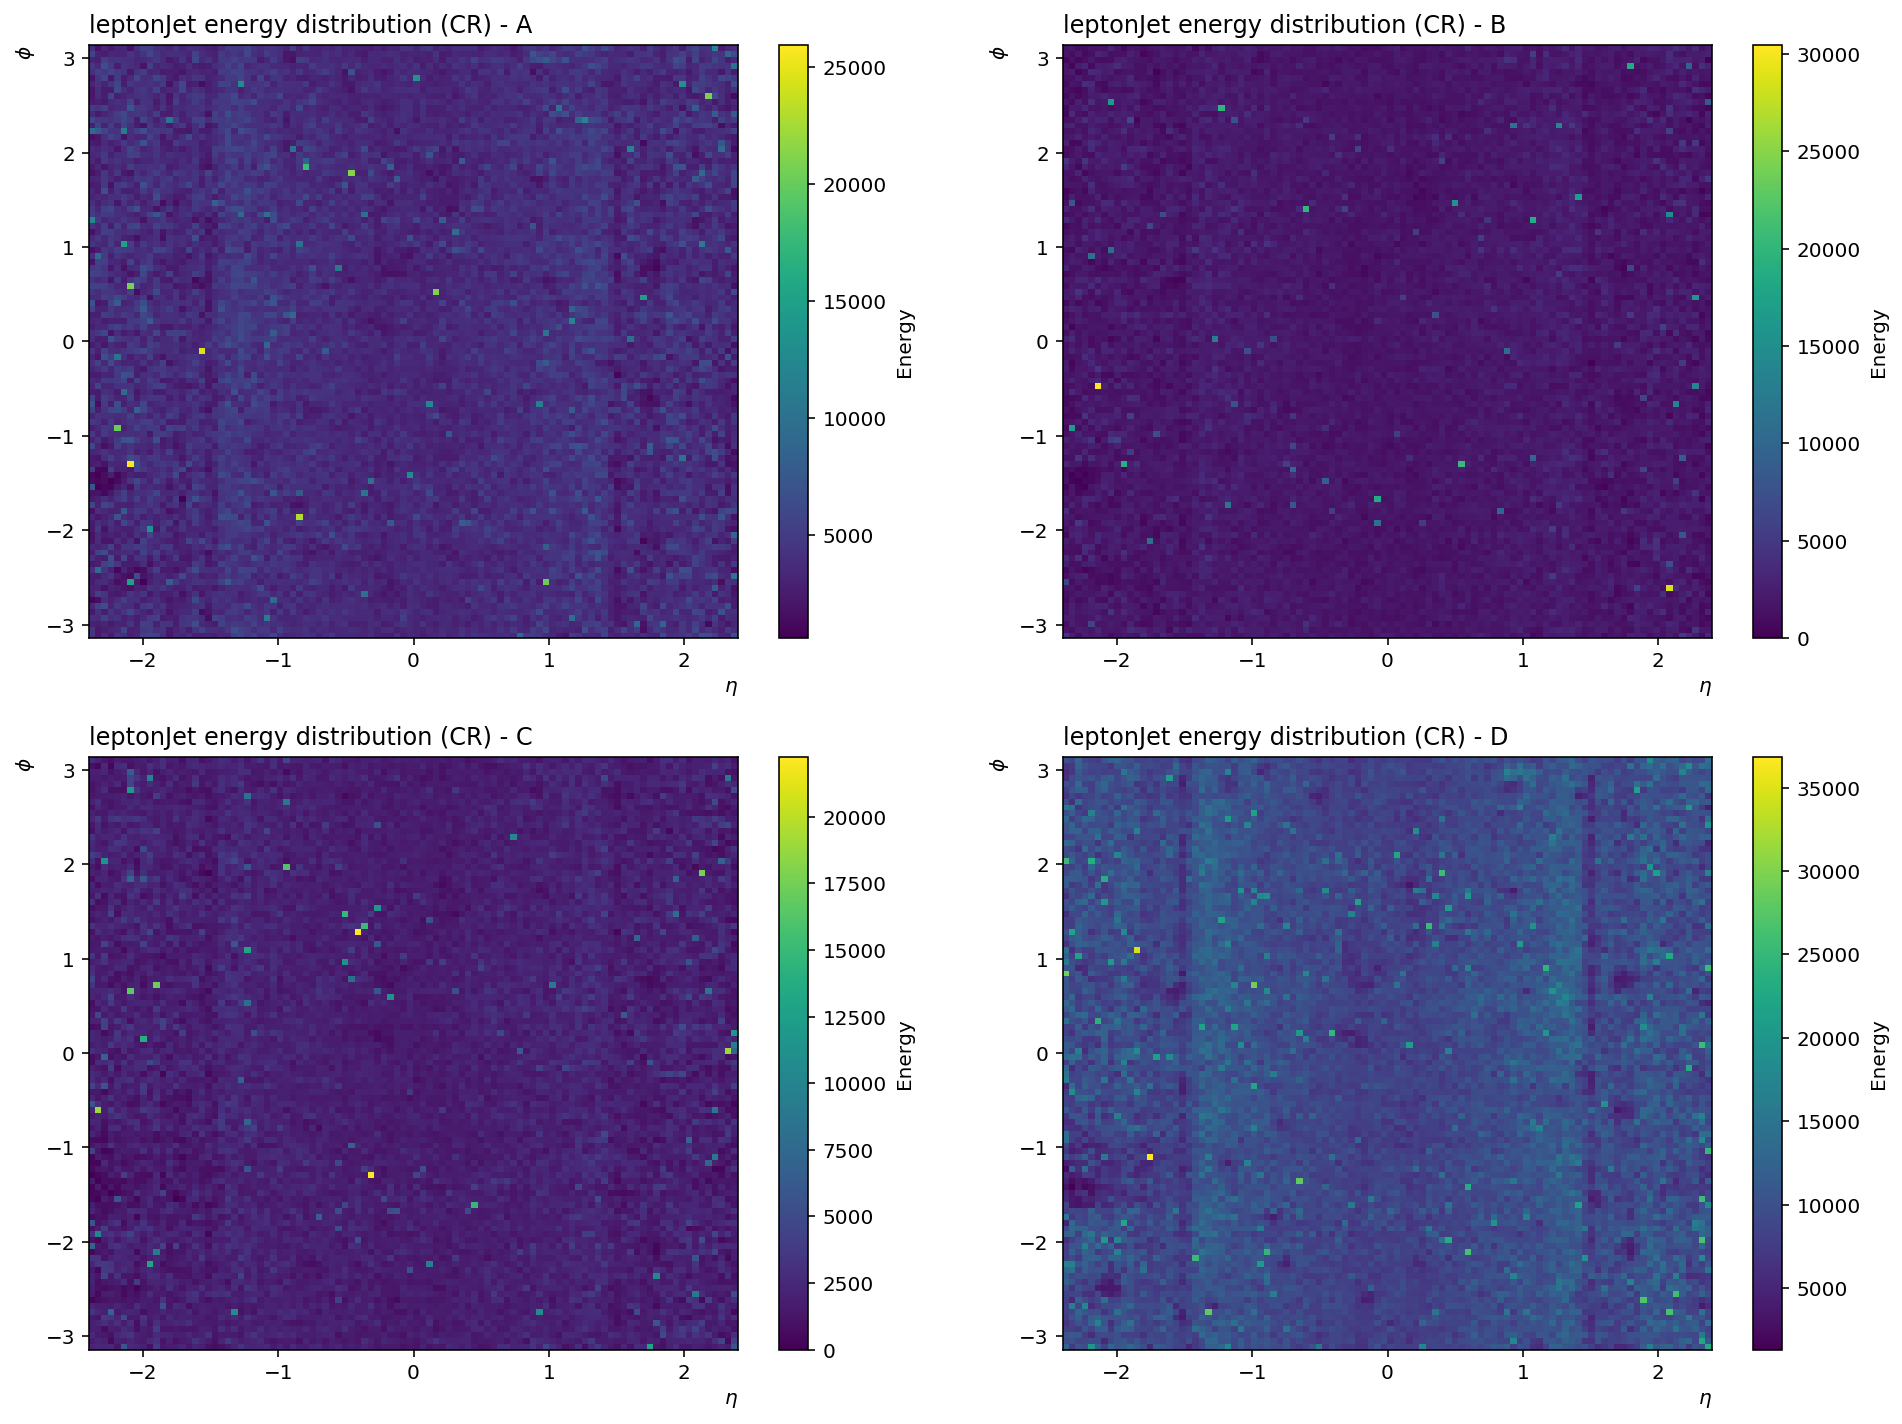

In [24]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
for i, era in enumerate(list('ABCD')):
    hist.plot2d(output['energy'].project('dataset', era), xaxis='eta', ax=axes.flat[i], density=False)

    axes.flat[i].set_title('leptonJet energy distribution (CR) - '+era, x=0.0, ha="left")
    axes.flat[i].set_xlabel(axes.flat[i].get_xlabel(), x=1.0, ha="right")
    axes.flat[i].set_ylabel(axes.flat[i].get_ylabel(), y=1.0, ha="right");

outliers are always present